In [1]:
# basic python data handling analysis modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
# small utility functions
from utility import *

# interactive jupyter widgets!
# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

In [40]:
# Needed for Factor Analysis
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    
    

In [3]:

def display_components(n_components, decomp, cols, BES_decomp, manifest, 
                       save_folder = False, show_first_x_comps=4,
                       show_histogram=True, flip_axes=True):
    
    if hasattr(decomp, 'coef_'):
        decomp_components = decomp.coef_
    elif hasattr(decomp, 'components_'):
        decomp_components = decomp.components_
    else:
        raise ValueError('no component attribute in decomp')    

    # hardcoded at 20?    
    n_comps = min(n_components,20)
    comp_labels = {}
    comp_dict = {}

    for comp_no in range(0,n_comps):

        fig, axes = plt.subplots(ncols=1+show_histogram)
        
        comp = pd.DataFrame( decomp_components[comp_no], index = cols, columns = ["components_"] )
        comp["comp_absmag"] = comp["components_"].abs()
        comp = comp.sort_values(by="comp_absmag",ascending=True)        
        
        if show_histogram:
            comp_ax = axes[0]
            
            hist_ax = axes[1]
            hist_ax.set_xlabel("abs. variable coeffs")
            hist_ax.set_title("Histogram of abs. variable coeffs")
            comp["comp_absmag"].hist( bins=30, ax=hist_ax, figsize=(10,6) )
            
        else:
            comp_ax = axes
            
        # set top abs_mag variable to label
        comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
        # if top abs_mag variable is negative
     
        if flip_axes & (comp[-1:]["components_"].values[0] < 0):

            comp["components_"]         = -comp["components_"]
            decomp_components[comp_no]  = -decomp_components[comp_no]
            BES_decomp[comp_no]         = -BES_decomp[comp_no]

        if manifest is not None:
            dataset_description = manifest["Friendlier_Description"].values[0]
            title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
            comp_labels[comp_no] = title
            comp_ax.set_title( dataset_description + "\n" + title )
            comp_ax.set_xlabel("variable coeffs")
            xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
            comp["components_"].tail(30).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
            dataset_citation = "Source: " + manifest["Citation"].values[0]

            if (save_folder != False):
                comp_ax.annotate(dataset_citation, (0,0), (0, -40),
                                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)            
                fname = save_folder + clean_filename(title) + ".png"
                fig.savefig( fname, bbox_inches='tight' )
        else:
            title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
            comp_labels[comp_no] = title
            comp_ax.set_title( title )
            comp_ax.set_xlabel("variable coeffs")    
            xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
            comp["components_"].tail(30).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
            
        comp_dict[comp_no] = comp
        # show first x components
        if (comp_no >= min(show_first_x_comps,n_components)):
            plt.close()

        
    return (BES_decomp, comp_labels, comp_dict)
    

def display_pca_data(n_components, decomp, BES_std, y=[]):    
    
    figsz = (16,3)
    
    f, axs = plt.subplots( 1, 4, figsize=figsz )

    axno = 0
    
    if hasattr(decomp, 'explained_variance_ratio_'):
        print('explained variance ratio (first 30): %s'
              % str(decomp.explained_variance_ratio_[0:30]) )
        
    if hasattr(decomp, 'explained_variance_'):
        print('explained variance (first 30): %s'
              % str(decomp.explained_variance_[0:30]) )

        axs[axno].plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
        # ,figsize = figsz)
        axs[axno].set_xlabel('n_components')
        axs[axno].set_ylabel('explained_variance_')
        axs[axno].set_title('explained variance by n_components')
        axno = axno + 1
        
    if hasattr(decomp, 'noise_variance_'): 
        if isinstance(decomp.noise_variance_, float):
            print('noise variance: %s'
                  % str(decomp.noise_variance_) )
        
    if hasattr(decomp, 'score'):
        if len(y)==0:
            print('average log-likelihood of all samples: %s'
                  % str(decomp.score(BES_std)) )
        else:
            print('mean classification accuracy (harsh if many cats.): %s'
                  % str(decomp.score(BES_std, y)) )
        
    if hasattr(decomp, 'score_samples') and not np.isinf( decomp.score(BES_std) ):
        pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz, ax=axs[axno])
        axs[axno].set_xlabel('log likelihood')
        axs[axno].set_ylabel('frequency')
        axs[axno].set_title('LL of samples')
        axno = axno + 1

    if hasattr(decomp, 'n_iter_'):
        print('number of iterations: %s'
              % str(decomp.n_iter_) )
        
    if hasattr(decomp, 'loglike_'):
        axs[axno].plot( decomp.loglike_, linewidth=2) # ,figsize = figsz)
        axs[axno].set_xlabel('n_iter')
        axs[axno].set_ylabel('log likelihood')
        axs[axno].set_title('LL by iter')
        axno = axno + 1

    if hasattr(decomp, 'error_'):

        axs[axno].plot( decomp.error_, linewidth=2, figsize = figsz)
        axs[axno].set_xlabel('n_iter')
        axs[axno].set_ylabel('error')
        axs[axno].set_title('LL by iter')
        axno = axno + 1
    

In [3]:
# The Movies Dataset
    # TMB_movies_metadata -> TMB_movies_metadata.csv
        # collections -> TMB_collections.csv
        # langs -> TMB_langs.csv
        # prod_companies -> TMB_prod_companies.csv
        # prod_countries -> TMB_prod_countries.csv

    # TMB_links
        # TMB_links_amalgamated -> TMB_links_amalgamated.csv

    # TMB_keywords -> TMB_keywords.csv (can be merged with TMB_movies_metadata)
    #    TMB_keys -> TMB_keys.csv

    # TMB_credits -> DONE it's job
    #    TMB_crew -> TMB_crew.csv
    #       TMB_crew_individuals -> TMB_crew_individuals.csv
    #    TMB_cast -> TMB_cast.csv
    #       TMB_cast_individuals -> TMB_crew_individuals.csv


# adult : bool -> int
# belongs_to_collection : int id -> collection df
    # collection
# budget, revenue: float (lot of fixes), budget, budget_normalised, revenue, revenue_normalised, revenue_divided_by_budget, revenue_divided_by_budget_normalised
# genres : dummied into bool genres_<Genres>, int num_genres_per_movie**
# homepage : left as string, int num_other_movies_with_same_homepage*
# id, imdb_id : dropped as already covered in TMB_links_amalgamated
# original_language : int points at lang df ids, num_langs_per_movie**
# spoken_languages: list of ints pointing at lang df ids
    # langs
# original_title, title: left as strings, bool original_title_differs_from_title, int title_used_by_num_other_movies**
# overview: left as string (some cleaning), int overview_length**
# popularity: float (0-550+), float popularity_normalised
# poster_path: string - jpgs, few pngs mostly consistent format left as is
# production_companies: strings -> converted to list int ids pointing at prod_companies df, int num_production_companies**
    # prod_companies
# production_countries : strings -> converted to list int id pointing at production_countries df, int num_production_countries**
    # prod_countries
# release_date : converted to datetime object, int release_year, int release_month, int release_day, str release_decade, int years_since_first_movie
#    (release_decade should be dummied)
# runtime : float, some "films" (>300mins) actually clearly tv so created tv_not_film (with exceptions for actually v long films)
# status: str categories (just 6), could dummy but almost all is in 'released', so just make dummy bool status_released
# tagline: str bit of cleaning otherwise left as is, int tagline_length, int num_other_movies_with_same_tagline
# video: bool, mostly false - not 100% clear what this is (no cinema release?)
# vote_count, vote_average: int/float, some cleaning (0 votes -> vote_average=0 -> np.nan), vote_average_normalised
#    (tried to normalise vote_count - complete failure!)

# movieId: int - one unique id I want for the dataset/to link to other datasets (also set as index, just conv to have as columns)


# ** (maybe don't normalised unless important?)    


In [4]:
# TMB_files = ["TMB_movies_metadata","TMB_collections","TMB_langs","TMB_prod_companies","TMB_prod_countries",
# "TMB_links_amalgamated","TMB_keywords","TMB_keys","TMB_crew","TMB_crew_individuals","TMB_cast","TMB_cast_individuals"]


# The Movies Dataset
    # TMB_movies_metadata -> TMB_movies_metadata.csv
        # collections -> TMB_collections.csv
        # langs -> TMB_langs.csv
        # prod_companies -> TMB_prod_companies.csv
        # prod_countries -> TMB_prod_countries.csv

    # TMB_links
        # TMB_links_amalgamated -> TMB_links_amalgamated.csv

    # TMB_keywords -> TMB_keywords.csv (can be merged with TMB_movies_metadata)
    #    TMB_keys -> TMB_keys.csv

    # TMB_credits -> DONE it's job -> ditched
    #    TMB_crew -> TMB_crew.csv (one row per credit)
    #       TMB_crew_individuals -> TMB_crew_individuals.csv
    #    TMB_cast -> TMB_cast.csv(one row per credit)
    #       TMB_cast_individuals -> TMB_cast_individuals.csv

In [5]:
Dataset_directory = ".."+os.sep+"Datasets"+os.sep

TMB_movies_metadata = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_movies_metadata"+".csv",index_col='movieId.1' )
TMB_movies_metadata.index = TMB_movies_metadata["movieId"]

TMB_collections = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_collections"+".csv",index_col="Unnamed: 0")
TMB_collections.index = TMB_collections["id"]

TMB_langs = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_langs"+".csv",index_col="Unnamed: 0")
TMB_langs.index = TMB_langs["id"]

TMB_prod_companies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_prod_companies"+".csv",index_col="id.1")
TMB_prod_companies.index = TMB_prod_companies["id"]

TMB_prod_countries = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_prod_countries"+".csv",index_col="iso_3166_1.1")
TMB_prod_countries.index = TMB_prod_countries["iso_3166_1"] # replace with numerical id??

TMB_links_amalgamated = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_links_amalgamated"+".csv",index_col="Unnamed: 0")
TMB_links_amalgamated.index = TMB_links_amalgamated["movieId"]

TMB_keywords = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_keywords"+".csv",index_col="Unnamed: 0")
TMB_keywords.index = TMB_keywords["movieId"]

TMB_keys = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_keys"+".csv",index_col="Unnamed: 0")
TMB_keys.index = TMB_keys["id"]

TMB_crew = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_crew"+".csv",index_col="Unnamed: 0")
TMB_crew.index = TMB_crew["credit_id"]

TMB_crew_individuals = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_crew_individuals"+".csv",index_col="Unnamed: 0")
TMB_crew_individuals.index = TMB_crew_individuals["id"]

TMB_cast = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast"+".csv",index_col="Unnamed: 0")
TMB_cast.index = TMB_cast["credit_id"]

TMB_cast_individuals = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast_individuals"+".csv",index_col="Unnamed: 0")
TMB_cast_individuals.index = TMB_cast_individuals["id"]
# gender 0=unknown, 1= female, 2= male

## data types tested!

In [6]:
TMB_keywords #-> merge with TMB_movies_metadata
TMB_movies_metadata["num_keywords"] = TMB_keywords["num_keywords"]
TMB_movies_metadata["keyword_id_list"] = TMB_keywords["keyword_id_list"]
del TMB_keywords

# TMB_crew -> crew size  - already covered because this is max_order!
# TMB_cast -> cast size  - already covered because this is max_order!

cast_size = TMB_cast.groupby("movieId").apply(lambda x: int(x["max_order"].mean()))
cast_list = TMB_cast.groupby("movieId").apply(lambda x: x["id"].values)

crew_size = TMB_crew.groupby("movieId").apply(lambda x: int(x["max_order"].mean()))
crew_list = TMB_crew.groupby("movieId").apply(lambda x: x["id"].values)

TMB_movies_metadata["cast_size"] = cast_size
TMB_movies_metadata["cast_list"] = cast_list

TMB_movies_metadata["crew_size"] = crew_size
TMB_movies_metadata["crew_list"] = crew_list
# remember, whole pile of movies with no cast/crew information!

cast_crew_intersection = intersection(TMB_crew["id"],TMB_cast["id"])
len(cast_crew_intersection)
# same id in cast/crew is the same individual!
# sadly, gender is the same in both sets (as in, when it's "0=unknown" in one, it's the same in the other)

14390

In [7]:
TMB_movies_metadata["collectionId"] = TMB_movies_metadata["belongs_to_collection"]
TMB_movies_metadata["belongs_to_collection"] = TMB_movies_metadata["belongs_to_collection"].notnull().astype('int')

In [ ]:
# 98% accuracy (assuming TMB gender is correct!) for "male"/"female" (84% of the names)
# 78% accuract for "mostly_female/mostly_male" (7% of the names)
# unknown -> 8%
# androgeneous -> 1.5%


import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)
TMB_crew_individuals["name"] = TMB_crew_individuals["name"].apply(lambda x: x.strip())
TMB_cast_individuals["name"] = TMB_cast_individuals["name"].apply(lambda x: x.strip())

TMB_crew_individuals["gender_guesser"] = TMB_crew_individuals["name"].apply(lambda x: d.get_gender( x.split(" ")[0] ) )
TMB_cast_individuals["gender_guesser"] = TMB_cast_individuals["name"].apply(lambda x: d.get_gender( x.split(" ")[0] ) )

In [8]:
TMB_movies_metadata.columns

Index(['movieId', 'adult', 'belongs_to_collection', 'budget', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'release_year',
 

In [237]:
bools = (TMB_movies_metadata.dtypes=='bool')
bool_cols = bools[bools].index
TMB_movies_metadata[bool_cols] = TMB_movies_metadata[bool_cols].astype('int')

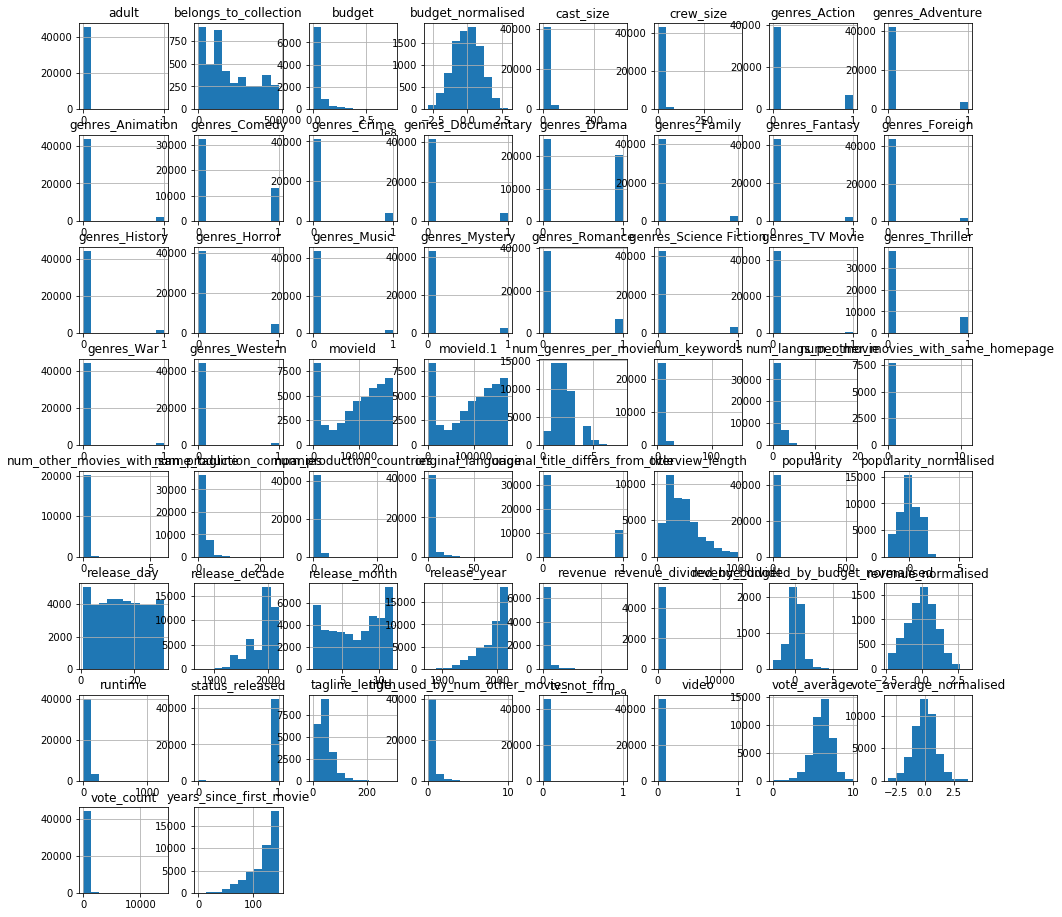

In [240]:
TMB_movies_metadata.hist(figsize =(16,16));
# belongs_to_collection -> could be renamed to be more clearly an id

In [ ]:
# TMB_langs -> need to get English language names!

In [273]:
# fix those 11 language nulls
TMB_movies_metadata.loc[TMB_movies_metadata["original_language"].isnull(),"original_language"] = 0
TMB_movies_metadata.loc[154832,"original_language"] = 18
TMB_movies_metadata.loc[172651,"original_language"] = 1
TMB_movies_metadata.loc[173819,"original_language"] = 4
TMB_movies_metadata.loc[173997,"original_language"] = 1
TMB_movies_metadata["original_language"] = TMB_movies_metadata["original_language"].astype('int')

In [276]:
original_language = TMB_movies_metadata["original_language"].copy()

language_dummy_number = 20

original_language_reduced = "language_"+original_language.apply(lambda x: TMB_langs.loc[x,"name"] if x<(language_dummy_number-1) else "Other")

original_language_reduced_dummied = pd.get_dummies(original_language_reduced)

TMB_movies_metadata[original_language_reduced_dummied.columns] = original_language_reduced_dummied

In [297]:
#### release decade --> dummy up!

In [300]:
objects = (TMB_movies_metadata.dtypes=='object') # lists, string - and one datetime object
object_cols = objects[objects].index
# TMB_movies_metadata[bool_cols] = TMB_movies_metadata[bool_cols].astype('int')
object_cols

Index(['homepage', 'original_title', 'overview', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'spoken_languages', 'status', 'tagline', 'title', 'keyword_id_list',
       'cast_list', 'crew_list'],
      dtype='object')

In [303]:
Id_columns = ["movieId","collectionId","original_language"]
unnormalised_columns = ["popularity","vote_average","budget","revenue","revenue_divided_by_budget"]

In [304]:
TMB_movies_numerical = TMB_movies_metadata.drop(object_cols,axis=1).drop(Id_columns,axis=1).drop(unnormalised_columns,axis=1).copy()

In [307]:
TMB_movies_numerical.describe()

,adult,belongs_to_collection,runtime,video,vote_count,genres_Adventure,genres_Fantasy,genres_Animation,genres_Drama,genres_Horror,...,language_Pусский,language_Türkçe,language_suomi,language_svenska,language_Český,language_हिन्दी,language_广州话 / 廣州話,language_日本語,language_普通话,language_한국어/조선말
count,45433.000000,45433.000000,43618.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,...,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000
mean,0.000198,0.098783,97.480352,0.002047,109.929545,0.076816,0.050822,0.042502,0.445579,0.102811,...,0.018181,0.003302,0.006493,0.008430,0.002883,0.011181,0.006889,0.029648,0.009002,0.009773
std,0.014073,0.298373,34.619451,0.045198,491.450762,0.266303,0.219637,0.201734,0.497035,0.303715,...,0.133606,0.057365,0.080318,0.091428,0.053620,0.105150,0.082716,0.169616,0.094453,0.098373
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,86.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,95.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,107.000000,0.000000,34.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1256.000000,1.000000,14075.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [310]:
TMB_movies_numerical.isnull().sum().sort_values().tail(20)

genres_TV Movie                             0
vote_count                                  0
genres_Action                               0
years_since_first_movie                    84
release_decade                             84
release_year                               84
crew_size                                 772
overview_length                          1114
runtime                                  1815
cast_size                                2415
vote_average_normalised                  2896
release_month                            3226
release_day                              3226
num_keywords                            19445
tagline_length                          25036
num_other_movies_with_same_tagline      25036
budget_normalised                       36553
num_other_movies_with_same_homepage     37659
revenue_normalised                      38035
revenue_divided_by_budget_normalised    40058
dtype: int64

7     8862
6     8514
4     8373
5     5076
3     3605
1     2809
8     2806
9     1847
0     1597
2      918
10     627
11     242
12      66
13      39
14      21
15      12
16      11
17       8
dtype: int64

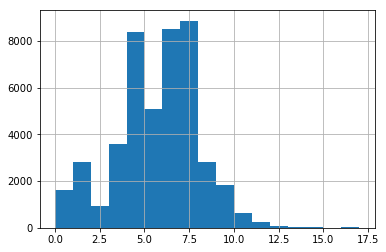

In [316]:
row_missingness = TMB_movies_numerical.isnull().sum(axis=1)
row_missingness.hist(bins=17)
row_missingness.value_counts()


In [315]:
TMB_movies_metadata[row_missingness>=17]

,movieId,adult,belongs_to_collection,budget,homepage,original_language,original_title,overview,popularity,poster_path,...,language_Pусский,language_Türkçe,language_suomi,language_svenska,language_Český,language_हिन्दी,language_广州话 / 廣州話,language_日本語,language_普通话,language_한국어/조선말
movieId,,,,,,,,,,,,,,,,,,,,,
90617,90617,0,0,NaN,NaN,16.0,Pajęczarki,NaN,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
92747,92747,0,0,NaN,NaN,13.0,Pölynimurikauppiaat,NaN,0.000000,NaN,...,0,0,1,0,0,0,0,0,0,0
99596,99596,0,0,NaN,NaN,13.0,Aurinkotuuli,NaN,0.000127,NaN,...,0,0,1,0,0,0,0,0,0,0
154386,154386,0,0,NaN,NaN,14.0,Normaal: Ik Kom Altied Weer Terug,NaN,0.000000,/fFBqjfnwTu4O02xfMRbMQfJfCA7.jpg,...,0,0,0,0,0,0,0,0,0,0
163010,163010,0,0,NaN,NaN,0.0,Bad Dad Rehab,NaN,0.000253,/oUgQBEPLA8VAZtu5krty5zgKV1u.jpg,...,0,0,0,0,0,0,0,0,0,0
166289,166289,0,0,NaN,NaN,5.0,Allende en su laberinto,NaN,0.000000,/4qVpxyEtTZek9NZeasOIKdKOOve.jpg,...,0,0,0,0,0,0,0,0,0,0
167098,167098,0,0,NaN,NaN,4.0,Dolpo Tulku - Heimkehr in den Himalaya,NaN,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
174953,174953,0,0,NaN,NaN,11.0,Mundo Cão,NaN,0.000331,NaN,...,0,0,0,0,0,0,0,0,0,0


In [323]:
TMB_movies_metadata_no_nan.columns

Index(['adult', 'belongs_to_collection', 'runtime', 'video', 'vote_count',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'release_year',
       'release_month', 'release_day', 'release_decade',
       'years_since_first_movie', 'tv_not_film',
       'num_other_movies_with_same_homepage', 'overview_length',
       'status_released', 'num_other_movies_with_same_tagline',
       'tagline_length', 'vote_average_normalise

In [319]:
TMB_movies_metadata_no_nan = TMB_movies_numerical.fillna(TMB_movies_numerical.mean()).copy()

In [322]:
TMB_movies_metadata_no_nan.to_stata(Dataset_directory+"Processed"+os.sep+ "TMB_movies_metadata_no_nan.dta")
# set up for doing Bayesian Belief Network fitting

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\pandas\io\stata.py:2136: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'genres_Science Fiction'   ->   genres_Science_Fiction
    b'genres_TV Movie'   ->   genres_TV_Movie
    b'original_title_differs_from_title'   ->   original_title_differs_from_titl
    b'num_other_movies_with_same_homepage'   ->   num_other_movies_with_same_homep
    b'num_other_movies_with_same_tagline'   ->   num_other_movies_with_same_tagli
    b'revenue_divided_by_budget_normalised'   ->   revenue_divided_by_budget_normal
    b'language_Espa\xc3\xb1ol'   ->   language_Espa_ol
    b'language_Fran\xc3\xa7ais'   ->   language_Fran_ais
    b'language_Portugu\xc3\xaas'   ->   language_Portugu_s
    b'language_P\xd1\x83\xd1\x81\xd1\x81\xd0\xba\xd0\xb8\xd0\xb9'   ->   language_P______
    b'language_T\xc3\xbcrk\xc3\xa7e'   ->   language_T_rk_e
    b'language_\xc

In [324]:
pattern = "revenue_divided_by_budget_normalised"
name = "revenue_divided_by_budget_normalised"
corr_type = "spearman"
df,corr_type = make_corr_summary(TMB_movies_numerical, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

## FIX display_corr not to overrun when limited pos/neg coe


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,r,p,N
revenue_normalised,0.6,0.00,5375
vote_count,0.4,0.00,5375
belongs_to_collection,0.31,0.00,5375
vote_average_normalised,0.3,0.00,5368
popularity_normalised,0.27,0.00,5375
num_keywords,0.2,0.00,4841
cast_size,0.18,0.00,5364
crew_size,0.14,0.00,5370
num_other_movies_with_same_homepage,0.11,0.00,1914
runtime,0.06,0.00,5363


In [325]:
pattern = "revenue_normalised"
name = "revenue_normalised"
corr_type = "spearman"
df,corr_type = make_corr_summary(TMB_movies_numerical, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

## FIX display_corr not to overrun when limited pos/neg coe


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,r,p,N
vote_count,0.72,0.00,7398
budget_normalised,0.71,0.00,5375
revenue_divided_by_budget_normalised,0.6,0.00,5375
popularity_normalised,0.59,0.00,7398
crew_size,0.43,0.00,7386
cast_size,0.41,0.00,7364
belongs_to_collection,0.31,0.00,7398
runtime,0.26,0.00,7371
num_production_companies,0.26,0.00,7398
genres_Adventure,0.25,0.00,7398


In [328]:
output_subfolder = ".."+os.sep+"Output"+os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(TMB_movies_metadata_no_nan.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = TMB_movies_metadata_no_nan.columns,
                             index   = TMB_movies_metadata_no_nan.index      )

%%time

n_components = BES_std.shape[1]
n_components = 10

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = TMB_movies_metadata_no_nan.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     BES_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 

display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          TMB_movies_metadata_no_nan.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = False)

In [14]:
[x for x in TMB_movies_metadata.columns if "revenue" in x]

['revenue',
 'revenue_divided_by_budget',
 'revenue_normalised',
 'revenue_divided_by_budget_normalised']

In [10]:
TMB_movies_metadata['num_production_countries'].value_counts()

1     32135
0      6279
2      4872
3      1468
4       460
5       151
6        38
7        12
8         7
9         5
11        2
25        1
15        1
12        1
10        1
Name: num_production_countries, dtype: int64

In [21]:
TMB_movies_metadata.sort_values(by = "revenue_divided_by_budget", ascending=True)[["title","revenue_divided_by_budget", "budget","revenue"]].dropna().head(50)

,title,revenue_divided_by_budget,budget,revenue
movieId,,,,
99746,The Samaritan,0.000210,12000000.0,2521.0
114856,The Adventurer: The Curse of the Midas Box,0.000256,25000000.0,6399.0
167478,The Guillotines,0.000353,15000000.0,5290.0
160581,The Duel,0.000450,10000000.0,4500.0
120102,Fishtales,0.000658,14000000.0,9216.0
101599,The Good Doctor,0.000868,6000000.0,5206.0
94998,5 Days of War,0.000874,20000000.0,17479.0
106881,Sweetwater,0.000878,7000000.0,6147.0
85226,Janky Promoters,0.000907,10000000.0,9069.0


In [ ]:
# The Boondock Saints

In [22]:
TMB_movies_metadata['num_production_countries'].value_counts()

1     32135
0      6279
2      4872
3      1468
4       460
5       151
6        38
7        12
8         7
9         5
11        2
25        1
15        1
12        1
10        1
Name: num_production_countries, dtype: int64

In [35]:
rev_by_prod_country

,revenue_divided_by_budget
production_countries,
AU,13.996280
BE,2.678571
BG,0.259237
BR,1.207504
CA,1.324851
CN,6.852953
DE,7.988435
DK,1.132438
ES,3.533293


In [41]:
# 
mask = TMB_movies_metadata['num_production_countries']==1
countries = TMB_movies_metadata['production_countries'][mask].apply(lambda x: eval(x)[0])
rev_by_prod_country = pd.concat([ TMB_movies_metadata["revenue_divided_by_budget"][mask],
                                  countries,
                                  ],axis=1).groupby("production_countries").mean().dropna()
num_by_prod_country = pd.concat([ TMB_movies_metadata["revenue_divided_by_budget"][mask],
                                  countries,
                                  ],axis=1).groupby("production_countries").apply(lambda x: x.shape[0]).dropna()
# rev_by_prod_country.sort_values(by = "revenue_divided_by_budget")
rev_by_prod_country["N"] = num_by_prod_country.loc[rev_by_prod_country.index]
# rev_by_prod_country.sort_values(by = "revenue_divided_by_budget")

In [55]:
TMB_movies_metadata[mask][countries=="RO"][["title","overview","release_year"]]

,title,overview,release_year
movieId,,,
27271,Taboo,Six young adults struggle with their personal ...,2002.0
34729,One Point O,Paranoid computer programmer Simon wakes up to...,2004.0
47150,The Death of Mr. Lazarescu,Mr. Lazarescu (Ion Fiscuteanu) is a retired Ro...,2005.0
52796,West,"""Occident"" is a bitter comedy about the people...",2002.0
54426,12:08 East of Bucharest,It's the 22nd of December. Sixteen years have ...,2006.0
64099,Stuff and Dough,A young man from Constanța who has his own bus...,2001.0
65651,Fire and Ice: The Dragon Chronicles,Princess Luisa and knight Gabriel must face a ...,2008.0
67422,California Dreamin',Romanian director Cristian Nemescu's comedy Ca...,2007.0
72491,"Police, Adjective",A cop named Cristi must go undercover to trail...,2009.0


In [ ]:
# Police, Adjective

In [53]:
rev_by_prod_country.sort_values(by = "revenue_divided_by_budget")

,revenue_divided_by_budget,N
production_countries,,
RO,0.044336,51
BG,0.259237,7
TW,0.380805,63
SG,0.532710,12
ID,0.583824,23
UA,0.691289,16
FI,0.859642,269
RS,0.913000,35
TH,1.051372,72


In [ ]:
# Hong Kong??? ->> Bruce Lee???

In [ ]:
PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast"+".csv")

In [84]:
big5_corr_df = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
big5_corr_df.index = big5_corr["movieId"]

In [38]:
# big5_corr_df

In [39]:
# TMB_movies_metadata

In [79]:
intersect = intersection(big5_corr_df.index,TMB_movies_metadata.index)
big5_corr_df["shared_coverage"] = False
big5_corr_df.loc[intersect,"shared_coverage"] = True

In [82]:
len(intersect)

31896

In [81]:
@interact
def show_articles_more_than(column=big5_corr_df.columns, x=(-1,1,.1), n=(2,100,1), lt=True, return_top=20):
    show_cols = ['title','release_year','overview','tagline','runtime','budget','revenue']
    if lt:
        mask = (big5_corr_df[column]<=-x) & (big5_corr_df["N"]>=n) & big5_corr_df["shared_coverage"]
        indices = big5_corr_df[ mask ].sort_values(by=column,ascending=True).index
#         return TMB_movies_metadata.loc[intersection(indices,TMB_movies_metadata.index)][show_cols].head(return_top)
    else:
        mask = (big5_corr_df[column]>=x) & (big5_corr_df["N"]>=n) & big5_corr_df["shared_coverage"]
        indices = big5_corr_df[ mask ].sort_values(by=column,ascending=False).index
    return pd.concat([big5_corr_df.loc[indices][column],
                      TMB_movies_metadata.loc[indices][show_cols]],
                         axis=1).head(return_top)

interactive(children=(Dropdown(description='column', options=('movieId', 'agreeableness_mean', 'agreeableness_…

In [70]:
TMB_movies_metadata.columns
# [['title','release_year','overview','tagline','runtime','budget','revenue']]

Index(['movieId', 'adult', 'belongs_to_collection', 'budget', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'release_year',
 

In [65]:
len( intersection( TMB_movies_metadata.index, big5_corr_df.index) )
# intersection = 31896
# big5_corr_df["movieId"] unique= 35196

31896

In [83]:
# big5_corr_df["movieId"].value_counts()

In [ ]:
# big5_corr_df = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
# big5_corr_df.index = big5_corr["movieId"]

In [122]:
LEARN_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"LEARN_movie_ratings.csv")
LEARN_movie_ratings.index = LEARN_movie_ratings["movieId"]

ML_links = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_links.csv",index_col="Unnamed: 0")
ML_links.index = ML_links["movieId"]

ML_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movie_ratings.csv")
ML_movie_ratings.index = ML_movie_ratings["movieId"]

ML_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movies.csv",index_col="Unnamed: 0")
ML_movies.index = ML_movies["movieId"]

PERS_big5_corr = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
PERS_big5_corr.index = PERS_big5_corr["movieId"]

PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_movie_ratings.csv")
PERS_movie_ratings.index = PERS_movie_ratings["movieId"]

SER_answers_by_movieId = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_answers_by_movieId.csv")
SER_answers_by_movieId.index = SER_answers_by_movieId["movieId"]

SER_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movie_ratings.csv")
SER_movie_ratings.index = SER_movie_ratings["movieId"]

SER_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movies.csv",index_col="Unnamed: 0")
SER_movies.index = SER_movies["movieId"]

HETREC_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_movies"+".csv",index_col="id.1")
HETREC_movies.index = HETREC_movies["id"]

HETREC_user_ratings= pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_user_ratings"+".csv")
HETREC_user_ratings.index =HETREC_user_ratings["movieID"]

In [11]:
TMB_movies_metadata.shape, TMB_links_amalgamated.shape, len( intersection( TMB_movies_metadata.index,TMB_links_amalgamated.index ) )

((45433, 65), (45845, 3), 45433)

In [12]:
ML_links.shape, ML_movie_ratings.shape, ML_movies.shape

((58098, 3), (53889, 4), (58098, 3))

In [13]:
TMB_movies_metadata.shape, ML_movies.shape, len( intersection( TMB_movies_metadata.index,ML_movies.index ) )

((45433, 65), (58098, 3), 45410)

In [14]:
TMB_movies_metadata.shape, LEARN_movie_ratings.shape, len( intersection( TMB_movies_metadata.index,LEARN_movie_ratings.index ) )

((45433, 65), (13012, 4), 12887)

In [17]:
PERS_big5_corr.shape, PERS_movie_ratings.shape

((35196, 22), (35196, 4))

In [16]:
TMB_movies_metadata.shape, PERS_movie_ratings.shape, len( intersection( TMB_movies_metadata.index,PERS_movie_ratings.index ) )

((45433, 65), (35196, 4), 31896)

In [18]:
SER_answers_by_movieId.shape, SER_movie_ratings.shape, SER_movies.shape

((1678, 21), (49151, 4), (49174, 15))

In [22]:
TMB_movies_metadata.shape, SER_movies.shape, len( intersection( TMB_movies_metadata.index,SER_movies.index ) )

((45433, 65), (49174, 15), 44607)

In [33]:
HETREC_movies.shape, HETREC_user_ratings.shape

((10197, 24), (10109, 4))

In [34]:
TMB_movies_metadata.shape, HETREC_movies.shape, len( intersection( TMB_movies_metadata.index,HETREC_movies.index ) )

((45433, 65), (10197, 24), 10150)

In [133]:
TMB_links_amalgamated.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [134]:
ML_links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [489]:
HETREC_links = HETREC_movies[["id","imdbID"]].copy()
HETREC_links.columns = ["movieId","imdbId"]

SER_links = SER_movies[['movieId', 'imdbId', 'tmdbId']].copy()

In [490]:
all_links = TMB_links_amalgamated.copy()
all_links = all_links.append(ML_links,ignore_index=True,sort=False)
all_links = all_links.append(SER_links,ignore_index=True,sort=False)
all_links = all_links.append(HETREC_links,ignore_index=True,sort=False)
all_links = all_links.drop_duplicates().copy()
all_links.drop([60996, 89829],inplace=True)
# movieId now unique (when you drop tmdbId nulls)

In [491]:
# fill in blank tmdbIds where they match movieIds

uni_movieId_no_nans = all_links[["movieId","imdbId","tmdbId"]].dropna().drop_duplicates().copy()
uni_movieId_no_nans = uni_movieId_no_nans.set_index("movieId")
uni_movieId_no_nans["tmdbId"] = uni_movieId_no_nans["tmdbId"].astype('int')

tmdbId_nulls = all_links["tmdbId"].isnull()

all_links.loc[tmdbId_nulls, "tmdbId"] = all_links[ tmdbId_nulls ].apply(lambda x: uni_movieId_no_nans.loc[x["movieId"],"tmdbId"] if x["movieId"] in uni_movieId_no_nans.index else np.nan, axis=1)

In [492]:
# squeeze out duplicates
imdbIds = all_links[['movieId', 'imdbId', 'tmdbId']].groupby("movieId").apply(lambda x: x["imdbId"].unique())
tmdbIds = all_links[['movieId', 'imdbId', 'tmdbId']].groupby("movieId").apply(lambda x: [int(y) for y in x["tmdbId"].dropna().unique()])


all_links = pd.DataFrame([imdbIds.index, imdbIds.values, tmdbIds.values ]).transpose()
all_links.columns = ['movieId', 'imdbId', 'tmdbId']
# imdbId has 1 or 2 entries (57858/1082)
# tmdbId has 0 or 1 entries (57978/962)
all_links.index = all_links["movieId"]

In [493]:
all_links["SER_title"] = all_links.apply(lambda x: SER_movies.loc[x["movieId"],"title"] if x["movieId"] in SER_movies.index else np.nan,axis=1)
all_links["ML_title"] = all_links.apply(lambda x: ML_movies.loc[x["movieId"],"title"] if x["movieId"] in ML_movies.index else np.nan,axis=1)
all_links["HETREC_title"] = all_links.apply(lambda x: HETREC_movies.loc[x["movieId"],"title"] + " ("+str( HETREC_movies.loc[x["movieId"],"year"] )+ ")" if x["movieId"] in HETREC_movies.index else np.nan,axis=1)

all_links["TMB_title"] = all_links.apply(lambda x: TMB_movies_metadata.loc[x["movieId"],"title"] + " ("+str( int( np.nan_to_num( TMB_movies_metadata.loc[x["movieId"],"release_year"] ) ) )+ ")" if x["movieId"] in TMB_movies_metadata.index else np.nan,axis=1)


In [494]:
title_cols = ['SER_title', 'ML_title', 'HETREC_title',
       'TMB_title']

titles = all_links[['SER_title', 'ML_title', 'HETREC_title',
       'TMB_title']].stack().unique()
titles_only = [x.split("(")[0].strip() for x in titles]

NUM_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"NUM_movies"+".csv", index_col = "Unnamed: 0")
NUM_movies.index = NUM_movies["scrape_count"]

NUM_titles = NUM_movies.apply(lambda x: x["title"] + " ("+str(x["release_year"])+")",axis=1)
NUM_titles_only = NUM_movies.apply(lambda x: x["title"],axis=1)

NUM_titles = NUM_titles.apply(lambda x: x.lower())
NUM_titles_only = NUM_titles_only.apply(lambda x: x.lower())

# 5769 -> 1484 non-matches with title (year), 791 non-matches with just title
# NUM_titles.apply(lambda x: x not in titles).sum()
# NUM_titles_only.apply(lambda x: x not in titles_only).sum()
# NUM_titles.shape
NUM_movies[['production_budget', 'domestic_gross', 'worldwide_gross']] = NUM_movies[['production_budget', 'domestic_gross', 'worldwide_gross']].replace(0,np.nan)
NUM_movies[['production_budget', 'domestic_gross', 'worldwide_gross']].isnull().sum()

production_budget      0
domestic_gross       550
worldwide_gross      367
dtype: int64

In [509]:
title_cols = ['SER_title', 'ML_title', 'HETREC_title',
       'TMB_title']
all_links["title_and_year_list"] = all_links[title_cols].apply(lambda x: [y.lower() for y in x.dropna().unique()], axis=1)
all_links["title_list"] = all_links[title_cols].apply(lambda x: np.unique([y.split("(")[0].strip().lower() for y in x.dropna()]), axis=1)



In [522]:
# all_links[0:1][title_cols].apply(lambda x: [y.lower() for y in x.unique()], axis=1)

# all_links["title_and_year_list"]
# all_links

In [520]:
example = "avatar (2009)"

# list(filter(lambda x: x < 0, number_list))

Int64Index([72998], dtype='int64', name='movieId')

In [524]:
NUM_to_movieId = NUM_titles.apply(lambda x: all_links.index[ all_links["title_and_year_list"].apply(lambda y: x in y) ])


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


KeyboardInterrupt: 

In [532]:
# %%time
NUM_to_movieId_titles_only = NUM_titles_only.apply(lambda x: all_links.index[ all_links["title_list"].apply(lambda y: x in y )])

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [535]:
NUM_to_movieId_titles_only = NUM_to_movieId_titles_only.apply(lambda x: list(x))

In [539]:
NUM_to_movieId = NUM_to_movieId.apply(lambda x: list(x))

In [537]:
NUM_to_movieId_titles_only.apply(lambda x: len(x)).value_counts()

1     3937
2      770
0      676
3      212
4      102
5       36
6       13
7       10
10       3
9        3
8        3
16       2
12       2
dtype: int64

In [569]:
all_links["title_list"].apply(lambda x: len(x)).value_counts()

1    49025
2     9211
3      701
0        3
Name: title_list, dtype: int64

In [578]:
re.sub( "[^a-z]" , "",all_links["title_list"].loc[193851][0] )

'ujuly'

In [583]:
all_links["title_chars_only"] = all_links["title_list"].apply( lambda x: [ re.sub( "[^a-z]" , "", y) for y in x ] )

In [588]:
NUM_titles_chars_only = NUM_titles_only.apply( lambda x: re.sub( "[^a-z]" , "", x) )

In [590]:
NUM_to_movieId_titles_chars_only = NUM_titles_chars_only.apply(lambda x: all_links.index[ all_links["title_chars_only"].apply(lambda y: x in y )])

In [593]:
NUM_to_movieId_titles_chars_only = NUM_to_movieId_titles_chars_only.apply(lambda x: list(x))

In [622]:
NUM_to_movieId_plus_close_matches.apply( lambda x: len(x) ).value_counts()

1     4712
0      502
2      451
3       72
4       19
5        7
7        2
6        2
13       1
8        1
dtype: int64

In [803]:
NUM_to_movieId_plus_close_matches = NUM_to_movieId.copy()

no_guess = NUM_to_movieId_plus_close_matches.apply(lambda x: len(x)==0)
NUM_to_movieId_plus_close_matches[no_guess] = NUM_to_movieId_titles_only[no_guess]

still_no_guess = NUM_to_movieId_plus_close_matches.apply(lambda x: len(x)==0)
NUM_to_movieId_plus_close_matches[still_no_guess] = NUM_to_movieId_titles_chars_only[still_no_guess]

NUM_to_movieId_plus_close_matches.loc[669  ] = []
NUM_to_movieId_plus_close_matches.loc[3441 ] = []
NUM_to_movieId_plus_close_matches.loc[3976 ] = []
NUM_to_movieId_plus_close_matches.loc[5593 ] = []
NUM_to_movieId_plus_close_matches.loc[4836 ] = []
NUM_to_movieId_plus_close_matches.loc[3921 ] = [91035]
NUM_to_movieId_plus_close_matches.loc[2825 ] = [1411]
NUM_to_movieId_plus_close_matches.loc[3162 ] = [134823]
NUM_to_movieId_plus_close_matches.loc[1297 ] = [273]
NUM_to_movieId_plus_close_matches.loc[3865 ] = []
NUM_to_movieId_plus_close_matches.loc[1014 ] = [30816]
NUM_to_movieId_plus_close_matches.loc[2558 ] = [89085]
NUM_to_movieId_plus_close_matches.loc[4453 ] = [112091]
NUM_to_movieId_plus_close_matches.loc[4854 ] = [143703]
NUM_to_movieId_plus_close_matches.loc[5318 ] = [101741]

NUM_to_movieId_plus_close_matches.loc[5520 ] = [5870]
NUM_to_movieId_plus_close_matches.loc[5585 ] = []
NUM_to_movieId_plus_close_matches.loc[39]    = [41569]
NUM_to_movieId_plus_close_matches.loc[578]   = [49278]
NUM_to_movieId_plus_close_matches.loc[1094]  = [253]
NUM_to_movieId_plus_close_matches.loc[1146]  = [3285]

NUM_to_movieId_plus_close_matches.loc[1146]  = [3285]
NUM_to_movieId_plus_close_matches.loc[1230]  = [68522]

NUM_to_movieId_plus_close_matches.loc[1730]  = [64231]
NUM_to_movieId_plus_close_matches.loc[1994]  = [50003]
NUM_to_movieId_plus_close_matches.loc[2223]  = [55872]

NUM_to_movieId_plus_close_matches.loc[3036]  = []
NUM_to_movieId_plus_close_matches.loc[3136]  = [27834]
NUM_to_movieId_plus_close_matches.loc[3192]  = [70208]

NUM_to_movieId_plus_close_matches.loc[3428]  = [4640]
NUM_to_movieId_plus_close_matches.loc[3438]  = [116893]
NUM_to_movieId_plus_close_matches.loc[3652]  = [3509]
NUM_to_movieId_plus_close_matches.loc[4223]  = [127305]
NUM_to_movieId_plus_close_matches.loc[4412]  = [58207]

NUM_to_movieId_plus_close_matches.loc[4738]  = []
NUM_to_movieId_plus_close_matches.loc[4955]  = [101415]
NUM_to_movieId_plus_close_matches.loc[5371]  = []

NUM_to_movieId_plus_close_matches.loc[5765]  = []
NUM_to_movieId_plus_close_matches.loc[5568]  = [34330]
NUM_to_movieId_plus_close_matches.loc[5473]  = []
NUM_to_movieId_plus_close_matches.loc[5159]  = []
NUM_to_movieId_plus_close_matches.loc[4998]  = [67624]
NUM_to_movieId_plus_close_matches.loc[4696]  = [43333]


In [804]:

NUM_to_movieId_plus_close_matches.loc[3559]  = [1030]
NUM_to_movieId_plus_close_matches.loc[355]   = [102686]
NUM_to_movieId_plus_close_matches.loc[3169]  = [2471]
NUM_to_movieId_plus_close_matches.loc[4243]  = [104908]
NUM_to_movieId_plus_close_matches.loc[208]   = [5459]
NUM_to_movieId_plus_close_matches.loc[2454]  = [199223]
NUM_to_movieId_plus_close_matches.loc[1794]  = [36519]
NUM_to_movieId_plus_close_matches.loc[5339]  = [107955]
NUM_to_movieId_plus_close_matches.loc[1083]  = [149352]
NUM_to_movieId_plus_close_matches.loc[5178]  = [110603]
NUM_to_movieId_plus_close_matches.loc[4831]  = []
NUM_to_movieId_plus_close_matches.loc[5642]  = []
NUM_to_movieId_plus_close_matches.loc[5733]  = []
NUM_to_movieId_plus_close_matches.loc[1172]  = [196223]
NUM_to_movieId_plus_close_matches.loc[5653]  = [2459]
NUM_to_movieId_plus_close_matches.loc[2006]  = []
NUM_to_movieId_plus_close_matches.loc[2286]  = []
NUM_to_movieId_plus_close_matches.loc[1012]  = [1320]
NUM_to_movieId_plus_close_matches.loc[5447]  = [79254]
NUM_to_movieId_plus_close_matches.loc[256]   = [91104]
NUM_to_movieId_plus_close_matches.loc[5318]  = []
NUM_to_movieId_plus_close_matches.loc[4858]  = [1976]


In [805]:
def add_yr(title):
    year = int(re.search("\((\d+)\)",title).groups()[0]) + 1
    return re.sub("\((\d+)\)","("+str(year)+")",title)

def red_yr(title):
    year = int(re.search("\((\d+)\)",title).groups()[0]) - 1
    return re.sub("\((\d+)\)","("+str(year)+")",title)

    
# title = NUM_titles.loc[scrape_count]    
# add_yr(title),red_yr(title)

In [807]:

for scrape_count in NUM_movies[ NUM_to_movieId_plus_close_matches.apply(lambda x: len(x)>1) ].index:
    title = NUM_titles.loc[scrape_count]
    best_match = all_links.loc[ NUM_to_movieId_plus_close_matches.loc[scrape_count] ][title_cols]\
        .replace(np.nan,"")\
        .applymap(lambda x: x.lower())\
        .apply(lambda x: (x==title)|(x==red_yr(title))|(x==add_yr(title)) )\
        .sum(axis=1)\
        .sort_values(ascending=False)\
        .index[0]
    
    NUM_to_movieId_plus_close_matches.loc[scrape_count] = [best_match]
#     display(all_links.loc[ NUM_to_movieId_plus_close_matches.loc[scrape_count] ][title_cols])
#     display(NUM_movies.loc[scrape_count])
#     print(best_match)

In [808]:
NUM_to_movieId_plus_close_matches.apply( lambda x: len(x) ).value_counts()

1    5252
0     517
dtype: int64

In [809]:
NUM_to_movieId_plus_close_matches = NUM_to_movieId_plus_close_matches.apply(lambda x: x[0] if len(x)==1 else np.nan)

In [882]:
NUM_to_movieId_plus_close_matches

scrape_count
1        72998.0
2        86880.0
3       122892.0
4            NaN
5            NaN
6            NaN
7        53125.0
8       122898.0
9       136020.0
10       91529.0
11      103384.0
12       93363.0
13       81847.0
14       52722.0
15      122920.0
16      136864.0
17       98809.0
18       69844.0
19      106489.0
20      118696.0
21      170875.0
22      187595.0
23       46530.0
24      122896.0
25       63113.0
26       89745.0
27       45722.0
28      103042.0
29       59501.0
30       95510.0
          ...   
5740      6978.0
5741         NaN
5742     93267.0
5743     99487.0
5744         NaN
5745         NaN
5746         NaN
5747     47793.0
5748     87964.0
5749         NaN
5750      2361.0
5751         NaN
5752         NaN
5753      4252.0
5754     32988.0
5755      4645.0
5756         NaN
5757      1697.0
5758         NaN
5759         NaN
5760     91829.0
5761      3267.0
5762      8914.0
5763         NaN
5764         NaN
5765         NaN
5766      2579.0
5

In [885]:
NUM_movies["movieId"] = NUM_to_movieId_plus_close_matches
NUM_movies.to_csv(Dataset_directory+"Processed"+os.sep+"NUM_movies"+".csv")
# NUM_movies.index = NUM_movies["scrape_count"]

In [886]:
NUM_movies[NUM_movies["movieId"].isnull()]
#500 blanks left!!!!

,date,title,link,page_no,production_budget,domestic_gross,worldwide_gross,scrape_count,release_year,release_month,release_day,movieId
scrape_count,,,,,,,,,,,,
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,/movie/Star-Wars-Ep-VIII-The-Last-Jedi#tab=sum...,4,317000000,620181382.0,1.316722e+09,4,2017,12,15,NaN
5,2015-12-18,Star Wars Ep. VII: The Force Awakens,/movie/Star-Wars-Ep-VII-The-Force-Awakens#tab=...,5,306000000,936662225.0,2.053311e+09,5,2015,12,18,NaN
6,2018-04-27,Avengers: Infinity War,/movie/Avengers-Infinity-War#tab=summary,6,300000000,678815482.0,2.048134e+09,6,2018,4,27,NaN
59,2018-11-16,Fantastic Beasts: The Crimes of Grindelwald,/movie/Fantastic-Beasts-The-Crimes-of-Grindelw...,59,200000000,159555901.0,6.522201e+08,59,2018,11,16,NaN
62,2010-05-28,Prince of Persia: Sands of Time,/movie/Prince-of-Persia-Sands-of-Time#tab=summary,62,200000000,90759676.0,3.363597e+08,62,2010,5,28,NaN
64,2019-06-07,Dark Phoenix,/movie/Dark-Phoenix-(2019)#tab=summary,64,200000000,NaN,NaN,64,2019,6,7,NaN
72,2009-11-06,Disneyâs A Christmas Carol,/movie/Disneys-A-Christmas-Carol#tab=summary,72,190000000,137855863.0,3.157097e+08,72,2009,11,6,NaN
99,2017-07-07,Spider-Man: Homecoming,/movie/Spider-Man-Homecoming#tab=summary,99,175000000,334201140.0,8.801664e+08,99,2017,7,7,NaN
103,2018-11-21,Ralph Breaks The Internet,/movie/Ralph-Breaks-The-Internet-(2018)#tab=su...,3,175000000,201091711.0,5.242887e+08,103,2018,11,21,NaN


In [ ]:
### clumsy integration!

In [ ]:
LEARN_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"LEARN_movie_ratings.csv")
LEARN_movie_ratings.index = LEARN_movie_ratings["movieId"]

ML_links = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_links.csv",index_col="Unnamed: 0")
ML_links.index = ML_links["movieId"]

ML_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movie_ratings.csv")
ML_movie_ratings.index = ML_movie_ratings["movieId"]

ML_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movies.csv",index_col="Unnamed: 0")
ML_movies.index = ML_movies["movieId"]

PERS_big5_corr = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
PERS_big5_corr.index = PERS_big5_corr["movieId"]

PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_movie_ratings.csv")
PERS_movie_ratings.index = PERS_movie_ratings["movieId"]

SER_answers_by_movieId = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_answers_by_movieId.csv")
SER_answers_by_movieId.index = SER_answers_by_movieId["movieId"]

SER_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movie_ratings.csv")
SER_movie_ratings.index = SER_movie_ratings["movieId"]

SER_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movies.csv",index_col="Unnamed: 0")
SER_movies.index = SER_movies["movieId"]

HETREC_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_movies"+".csv",index_col="id.1")
HETREC_movies.index = HETREC_movies["id"]

HETREC_user_ratings= pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_user_ratings"+".csv")
HETREC_user_ratings.index =HETREC_user_ratings["movieID"]

In [853]:
# INT_df = TMB_movies_metadata.copy()
# INT_df.columns = ["TMB_"+x for x in INT_df.columns]
# print(INT_df.columns)
# INT_df.shape

In [845]:
# 55630 rows × 2 columns
45433+10197

55630

In [892]:
INT_df = TMB_movies_metadata.copy()
INT_df.columns = ["TMB_"+x for x in INT_df.columns]

temp = HETREC_movies.copy()
temp.columns = ["HETREC_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = HETREC_user_ratings.drop("movieID",axis=1).copy()
temp.columns = ["HETREC_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = SER_movie_ratings.drop("movieId",axis=1).copy()
temp.columns = ["SER_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = SER_movies.copy()
temp.columns = ["SER_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = SER_answers_by_movieId.copy()
temp.columns = ["SER_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = PERS_movie_ratings.drop("movieId",axis=1).copy()
temp.columns = ["PERS_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = PERS_big5_corr.copy()
temp.columns = ["PERS_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = ML_movies.copy()
temp.columns = ["ML_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = ML_movie_ratings.drop("movieId",axis=1).copy()
temp.columns = ["ML_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = NUM_movies.copy()
temp.index = NUM_movies["movieId"]
temp.columns = ["NUM_"+x for x in temp.columns]
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')



INT_df.to_csv(Dataset_directory+"Processed"+os.sep+"INT_df"+".csv")

In [895]:
INT_df.to_csv(Dataset_directory+"Processed"+os.sep+"INT_df"+".csv")

In [893]:
INT_df.shape

(59922, 180)

In [894]:
INT_df.columns
#[["HETREC_id","TMB_movieId"]]

Index(['TMB_movieId', 'TMB_adult', 'TMB_belongs_to_collection', 'TMB_budget',
       'TMB_homepage', 'TMB_original_language', 'TMB_original_title',
       'TMB_overview', 'TMB_popularity', 'TMB_poster_path',
       ...
       'NUM_link', 'NUM_page_no', 'NUM_production_budget',
       'NUM_domestic_gross', 'NUM_worldwide_gross', 'NUM_scrape_count',
       'NUM_release_year', 'NUM_release_month', 'NUM_release_day',
       'NUM_movieId'],
      dtype='object', length=180)

In [897]:
INT_df.dtypes.value_counts()

float64    128
object      52
dtype: int64

In [902]:
object_cols = INT_df.columns[INT_df.dtypes=='object']
object_cols

Index(['TMB_homepage', 'TMB_original_title', 'TMB_overview', 'TMB_poster_path',
       'TMB_production_companies', 'TMB_production_countries',
       'TMB_release_date', 'TMB_spoken_languages', 'TMB_status', 'TMB_tagline',
       'TMB_title', 'TMB_video', 'TMB_original_title_differs_from_title',
       'TMB_tv_not_film', 'TMB_status_released', 'TMB_keyword_id_list',
       'TMB_cast_list', 'TMB_crew_list', 'HETREC_title', 'HETREC_spanishTitle',
       'HETREC_imdbPictureURL', 'HETREC_rtID', 'HETREC_rtAllCriticsRating',
       'HETREC_rtAllCriticsNumReviews', 'HETREC_rtAllCriticsNumFresh',
       'HETREC_rtAllCriticsNumRotten', 'HETREC_rtAllCriticsScore',
       'HETREC_rtTopCriticsRating', 'HETREC_rtTopCriticsNumReviews',
       'HETREC_rtTopCriticsNumFresh', 'HETREC_rtTopCriticsNumRotten',
       'HETREC_rtTopCriticsScore', 'HETREC_rtAudienceRating',
       'HETREC_rtAudienceNumRatings', 'HETREC_rtAudienceScore',
       'HETREC_rtPictureURL', 'HETREC_country', 'HETREC_directorID',
   

In [903]:
float_cols = INT_df.columns[INT_df.dtypes=='float64']
float_cols

Index(['TMB_movieId', 'TMB_adult', 'TMB_belongs_to_collection', 'TMB_budget',
       'TMB_original_language', 'TMB_popularity', 'TMB_revenue', 'TMB_runtime',
       'TMB_vote_average', 'TMB_vote_count',
       ...
       'ML_ratings_std', 'NUM_page_no', 'NUM_production_budget',
       'NUM_domestic_gross', 'NUM_worldwide_gross', 'NUM_scrape_count',
       'NUM_release_year', 'NUM_release_month', 'NUM_release_day',
       'NUM_movieId'],
      dtype='object', length=128)

In [905]:
INT_df[float_cols].isnull().sum().sort_values()

ML_movieId                                   1824
ML_ratings_mean                              6033
ML_n                                         6033
SER_movieId_x                               10748
SER_imdbId                                  10748
SER_ratings_mean                            10771
SER_n_x                                     10771
SER_tmdbId                                  11710
SER_num_directors                           12210
SER_num_genres                              14060
SER_num_starring                            14295
TMB_genres_Family                           14489
TMB_genres_War                              14489
TMB_genres_Foreign                          14489
TMB_genres_TV Movie                         14489
TMB_num_genres_per_movie                    14489
TMB_num_production_countries                14489
TMB_title_used_by_num_other_movies          14489
TMB_popularity_normalised                   14489
TMB_num_production_companies                14489


In [912]:
drop_cols = [x for x in float_cols if "_x" in x]
drop_cols

['SER_n_x', 'SER_movieId_x']

In [913]:
drop_cols = drop_cols + [x for x in float_cols if re.search("movieId|_id|_imdbID|_imdbId|_tmdbId|_movieId",x)]
drop_cols

['SER_n_x',
 'SER_movieId_x',
 'TMB_movieId',
 'HETREC_id',
 'HETREC_imdbID',
 'SER_movieId_x',
 'SER_imdbId',
 'SER_tmdbId',
 'SER_movieId_y',
 'PERS_movieId',
 'ML_movieId',
 'NUM_movieId']

In [914]:
numerical_INT_df = INT_df[float_cols].drop(drop_cols,axis=1).copy()

In [915]:
numerical_INT_df.shape

(59922, 117)

In [923]:
numerical_INT_df.isnull().sum().sort_values()

ML_ratings_mean                              2396
ML_n                                         2396
SER_ratings_mean                             7134
SER_num_directors                            8573
SER_num_genres                              10423
SER_num_starring                            10658
TMB_adult                                   10852
TMB_genres_Music                            10852
TMB_genres_Family                           10852
TMB_genres_War                              10852
TMB_genres_Foreign                          10852
TMB_genres_TV Movie                         10852
TMB_popularity_normalised                   10852
TMB_num_langs_per_movie                     10852
TMB_title_used_by_num_other_movies          10852
TMB_genres_Mystery                          10852
TMB_num_production_companies                10852
TMB_num_production_countries                10852
TMB_num_genres_per_movie                    10852
TMB_genres_Science Fiction                  10852


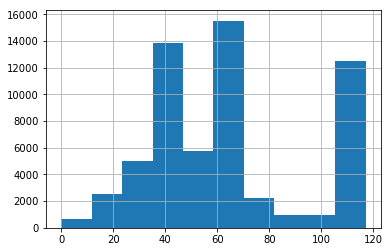

In [920]:
numerical_INT_df.isnull().sum(axis=1).sort_values().hist()

In [922]:
drop_movies = numerical_INT_df[numerical_INT_df.isnull().all(axis=1)].index
numerical_INT_df.drop(drop_movies,inplace=True)
drop_movies

Float64Index([ 25817.0,  26361.0,  27153.0,  27433.0,  31945.0,  52696.0,
               58209.0,  60234.0,  69834.0,  70312.0,
              ...
              191697.0, 191699.0, 191899.0, 191905.0, 191907.0, 192397.0,
              192399.0, 192933.0, 193109.0, 193321.0],
             dtype='float64', name='movieId', length=3637)

In [929]:
df = numerical_INT_df.fillna(numerical_INT_df.mean()).copy()

In [931]:
df_backup = df.copy()

In [952]:
df = df.drop(drop_cols, axis=1)

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\sklearn\decomposition\factor_analysis.py:237: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


average log-likelihood of all samples: -137.19892361694016
number of iterations: 1000
Wall time: 7min 37s


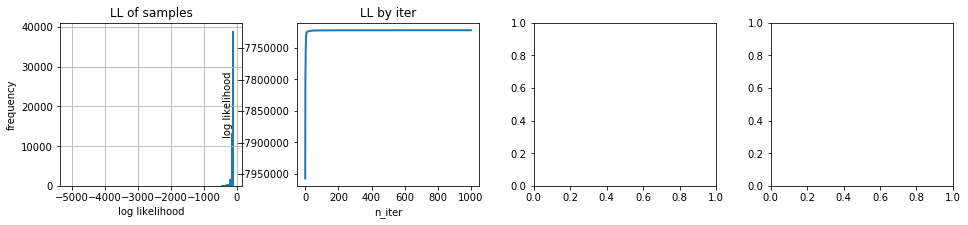

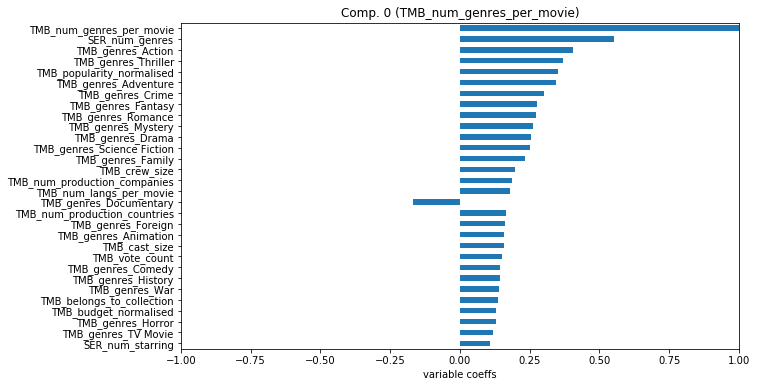

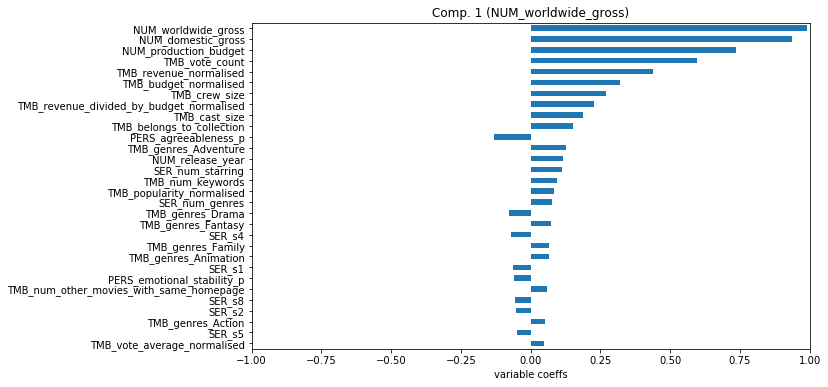

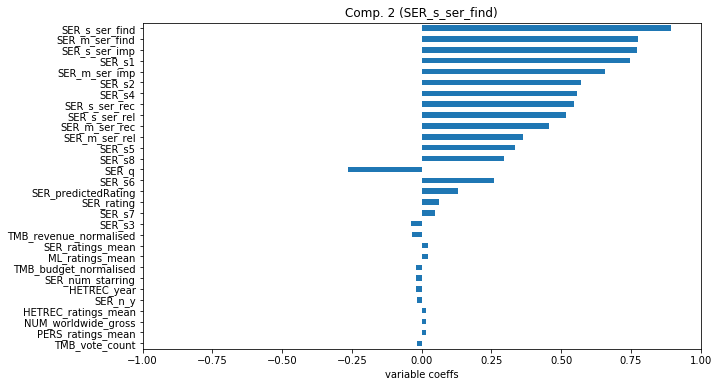

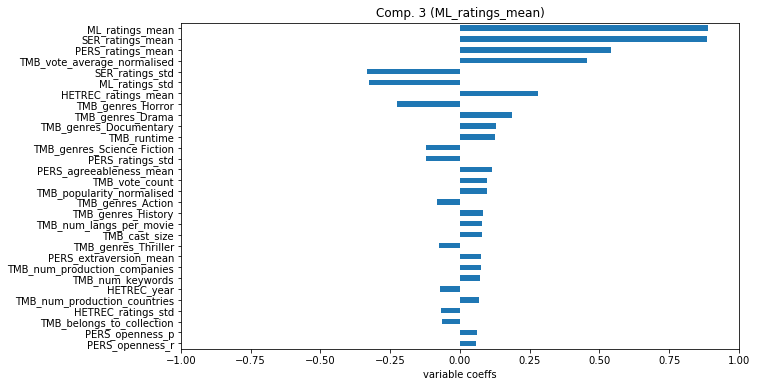

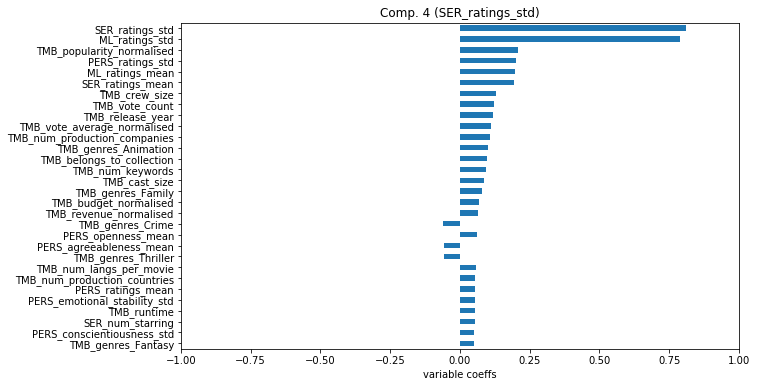

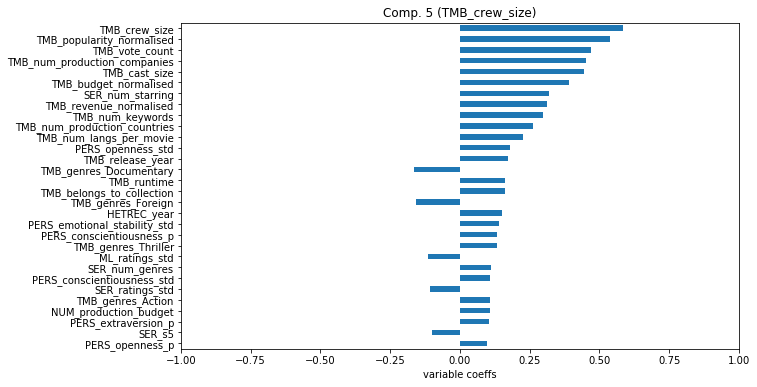

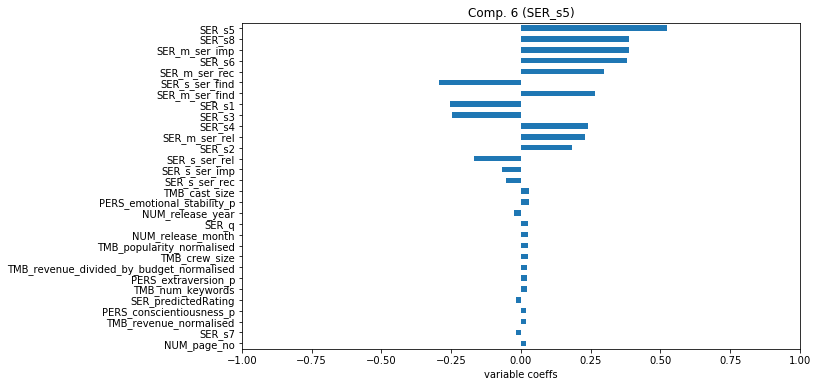

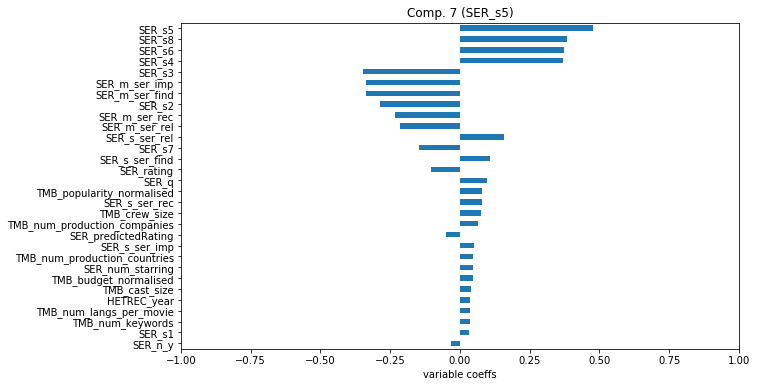

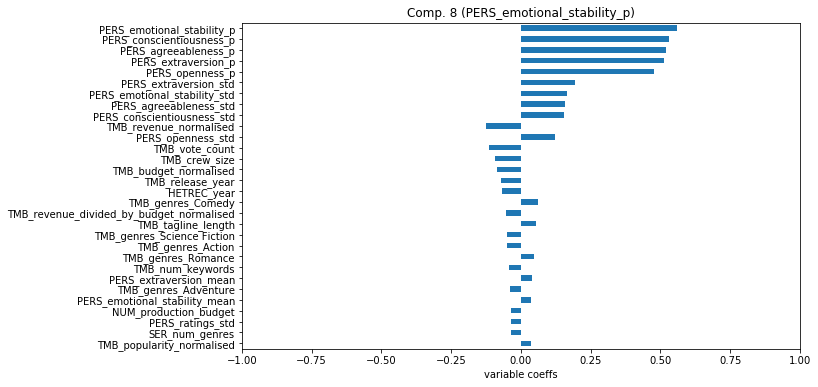

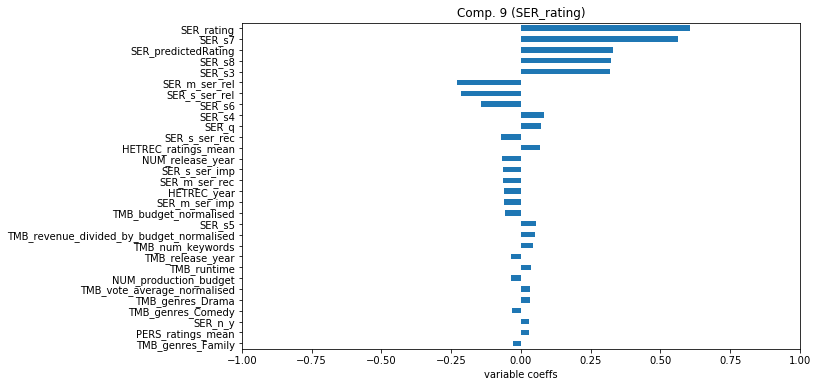

In [953]:
%%time
output_subfolder = ".."+os.sep+"Output"+os.sep+"INT_dataset_attempt1"
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
n_components = 10

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     BES_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 

display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= n_components, show_histogram = False)

In [943]:
[x for x in df.columns if re.search("id", x.lower())]

['TMB_revenue_divided_by_budget',
 'TMB_revenue_divided_by_budget_normalised',
 'TMB_collectionId',
 'NUM_worldwide_gross']

In [ ]:
drop_cols = [""]

In [940]:
[x for x in df.columns if re.search("normalised", x.lower())]

['TMB_popularity_normalised',
 'TMB_vote_average_normalised',
 'TMB_budget_normalised',
 'TMB_revenue_normalised',
 'TMB_revenue_divided_by_budget_normalised']

In [950]:


drop_cols = [x for x in df.columns if re.search("_n$", x.lower())]
drop_cols = drop_cols + ["NUM_scrape_count"]
Id_columns = ["collectionId","original_language"]
unnormalised_columns = ["popularity","vote_average","budget","revenue","revenue_divided_by_budget"]
repeat_cols = ["years_since_first_movie","release_decade"]
drop_cols = drop_cols+ ["TMB_"+x for x in (Id_columns+unnormalised_columns+repeat_cols)]

In [951]:
drop_cols

['HETREC_n',
 'PERS_n',
 'PERS_N',
 'ML_n',
 'NUM_scrape_count',
 'TMB_collectionId',
 'TMB_original_language',
 'TMB_popularity',
 'TMB_vote_average',
 'TMB_budget',
 'TMB_revenue',
 'TMB_revenue_divided_by_budget',
 'TMB_years_since_first_movie',
 'TMB_release_decade']

,noise_variance_
TMB_num_genres_per_movie,0.001360
NUM_worldwide_gross,0.015905
SER_s_ser_find,0.099137
NUM_domestic_gross,0.115714
ML_ratings_mean,0.165019
SER_ratings_mean,0.174680
SER_m_ser_find,0.213547
SER_ratings_std,0.220040
ML_ratings_std,0.255131
SER_m_ser_imp,0.298290


,noise_variance_
HETREC_ratings_mean,0.914935
HETREC_ratings_std,0.993454
HETREC_year,0.960440
NUM_page_no,0.999197
NUM_release_day,0.998569
NUM_release_month,0.996146
NUM_release_year,0.976353
PERS_agreeableness_mean,0.978673
PERS_agreeableness_r,0.999005
PERS_agreeableness_std,0.972303


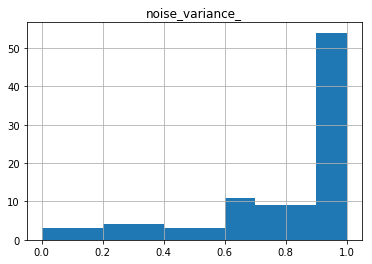

In [954]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [ ]:
##########################################

In [955]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False ):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(BES_output_folder,"xgb_census"+Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)
    

ModuleNotFoundError: No module named 'shap'

In [956]:
Treatment = "xgboost_imdb_data"
var_stub = "imdb_score"

var_list = ["imdb_score"]
var_stub_list = [var_stub]

# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = movie_metadata_cleaned.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return movie_metadata_cleaned[keep_list]


def create_target(target_var):
    
    return movie_metadata_cleaned[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



ModuleNotFoundError: No module named 'xgboost'

In [ ]:
%%time
colname = "imdb_score"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(movie_metadata_cleaned.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)

In [ ]:
## can we get decent-ish guesses for gender from names?





In [481]:
# TMB_crew_individuals
# TMB_cast_individuals
# cast_crew_intersection

In [9]:
TMB_all_individuals = TMB_crew_individuals.drop(cast_crew_intersection).append(TMB_cast_individuals, sort=False).copy()

In [10]:
TMB_all_individuals["gender"].value_counts()

0    265334
2     57254
1     30744
Name: gender, dtype: int64

In [11]:
labelled_data = TMB_all_individuals[["gender","name"]][ TMB_all_individuals["gender"]!=0 ].copy()

In [48]:
# conda install gender-guesser Genderize gender
# none on conda!
# conda install -c malev gender_detector -> conda hassle
# conda install -c auto genderize

# not nearly as clean to use pip ...
!pip install gender-guesser
# !pip install Genderize
# !pip install gender
# !pip install gender-detector

  Stored in directory: C:\Users\Marios\AppData\Local\pip\Cache\wheels\a6\78\0f\8c190b5c39c4737e1bd1111f5cd861a3c1fad7c29b1b2f0db1
Successfully built gender-detector


In [12]:
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)
# https://pypi.org/project/gender-guesser/
# The result will be one of unknown (name not found), andy (androgynous), male, female, mostly_male, or mostly_female.
# The difference between andy and unknown is that the former is found to have the same probability to be male than to be
# female, while the later means that the name wasn’t found in the database.

# can specify for country
# print(d.get_gender(u"Bob"))
# print(d.get_gender(labelled_data["first_name"].loc[9]))
# labelled_data["name"].loc[9]
# labelled_data["name"].apply(lambda x: d.get_gender(u"Bob"))

In [ ]:
!pip uninstall Genderize
!pip uninstall gender

In [14]:
labelled_data["number_of_names"] = labelled_data["name"].apply(lambda x: len(x.strip().split(" ")))
labelled_data["first_name"] = labelled_data["name"].apply(lambda x: x.strip().split(" ")[0] )
labelled_data["number_of_names"].value_counts()

2    79366
3     7748
1      566
4      306
5       11
6        1
Name: number_of_names, dtype: int64

In [16]:
labelled_data["name"][labelled_data["number_of_names"]==1].head(10)
## ????

id
4127     Orry-Kelly
4586          Pitof
6898             BT
9812          Homer
10189       Donfeld
11445      Travilla
29670          Mayo
36425           McG
38229         Renié
42379         Zlad!
Name: name, dtype: object

In [17]:
labelled_data["name"][labelled_data["number_of_names"]==3].head(10)
## ????

id
61       Robert Mark Kamen
123      Barrie M. Osborne
142    William Broyles Jr.
157        Thea von Harbou
277    Fernando Pérez Unda
414      Alan C. Blomquist
437         David J. Bomba
457        Albert S. Ruddy
466      David M. Thompson
511        Larry J. Franco
Name: name, dtype: object

In [18]:
labelled_data["gender_guesser"] = labelled_data["first_name"].apply(lambda x:d.get_gender(x))
# fast
labelled_data["gender_guesser"].value_counts()

male             49033
female           24591
unknown           7204
mostly_male       3137
mostly_female     2668
andy              1365
Name: gender_guesser, dtype: int64

In [23]:
labelled_data.groupby("gender_guesser").apply(lambda x: x["gender"].value_counts())

gender_guesser   
andy            2      803
                1      562
female          1    24046
                2      545
male            2    48271
                1      762
mostly_female   1     2056
                2      612
mostly_male     2     2678
                1      459
unknown         2     4345
                1     2859
Name: gender, dtype: int64

In [31]:
labelled_data["gender_guesser"].value_counts()[3:5].sum()/labelled_data.shape[0]

0.06596740835018977

In [4]:
from gender_detector import GenderDetector
detector = GenderDetector('us') # It can also be ar, uk, uy.
detector.guess('Marcos') # => 'male'

ImportError: cannot import name 'GenderDetector'

In [37]:
# 98% accuracy (assuming TMB gender is correct!) for "male"/"female" (84% of the names)
# 78% accuract for "mostly_female/mostly_male" (7% of the names)
# unknown -> 8%
# androgeneous -> 1.5%


import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

TMB_crew_individuals["gender_guesser"] = TMB_crew_individuals["name"].apply(lambda x: d.get_gender( x.strip().split(" ")[0] ) )
TMB_cast_individuals["gender_guesser"] = TMB_cast_individuals["name"].apply(lambda x: d.get_gender( x.strip().split(" ")[0] ) )

In [ ]:
############################################################################################
## Factor Analysis 
# 

In [42]:
PERS_big5_corr = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
PERS_big5_corr.index = PERS_big5_corr["movieId"]

# PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_movie_ratings.csv")
# PERS_movie_ratings.index = PERS_movie_ratings["movieId"]


In [44]:
PERS_big5_corr.isnull().sum()
#[PERS_big5_corr["N"]]

movieId                         0
agreeableness_mean              0
agreeableness_p             12402
agreeableness_r             12609
agreeableness_std           11092
conscientiousness_mean          0
conscientiousness_p         12379
conscientiousness_r         12577
conscientiousness_std       11092
emotional_stability_mean        0
emotional_stability_p       12380
emotional_stability_r       12558
emotional_stability_std     11092
extraversion_mean               0
extraversion_p              12340
extraversion_r              12517
extraversion_std            11092
openness_mean                   0
openness_p                  12469
openness_r                  12679
openness_std                11092
N                               0
dtype: int64

In [49]:
PERS_big5_corr[PERS_big5_corr["N"]>=2].isnull().sum()
# N=1 -> nans
# N=2 -> nans caused by ident. rating/personality score

movieId                        0
agreeableness_mean             0
agreeableness_p             1310
agreeableness_r             1517
agreeableness_std              0
conscientiousness_mean         0
conscientiousness_p         1287
conscientiousness_r         1485
conscientiousness_std          0
emotional_stability_mean       0
emotional_stability_p       1288
emotional_stability_r       1466
emotional_stability_std        0
extraversion_mean              0
extraversion_p              1248
extraversion_r              1425
extraversion_std               0
openness_mean                  0
openness_p                  1377
openness_r                  1587
openness_std                   0
N                              0
dtype: int64

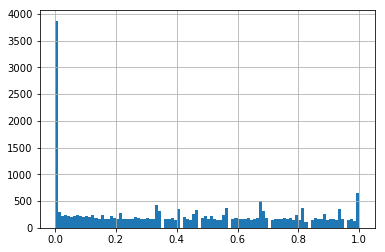

In [48]:
PERS_big5_corr["agreeableness_p"].hist(bins=100);

In [52]:
PERS_big5_corr[ (PERS_big5_corr["N"]>=2) & (PERS_big5_corr["agreeableness_p"].isnull())]["N"].value_counts()

2    1310
Name: N, dtype: int64

In [69]:
df = PERS_big5_corr.drop("movieId",axis=1)[PERS_big5_corr["N"]>2].copy()
df = df.replace(np.nan, 0)

agreeableness_mean          float64
agreeableness_p             float64
agreeableness_r             float64
agreeableness_std           float64
conscientiousness_mean      float64
conscientiousness_p         float64
conscientiousness_r         float64
conscientiousness_std       float64
emotional_stability_mean    float64
emotional_stability_p       float64
emotional_stability_r       float64
emotional_stability_std     float64
extraversion_mean           float64
extraversion_p              float64
extraversion_r              float64
extraversion_std            float64
openness_mean               float64
openness_p                  float64
openness_r                  float64
openness_std                float64
N                             int64
dtype: object

In [81]:
big5 = ['openness', 'agreeableness', 'emotional_stability',
       'conscientiousness', 'extraversion']

df_no_high_p = df.copy()
for pers in big5:
    non_sig = df_no_high_p[pers+"_p"]>0.05
    df_no_high_p.loc[non_sig,pers+"_r"] = 0
    df_no_high_p.loc[non_sig,pers+"_p"] = 0


In [74]:
df.corr()["N"].sort_values()

agreeableness_p            -0.200282
emotional_stability_p      -0.128284
extraversion_p             -0.100455
openness_p                 -0.077047
conscientiousness_p        -0.073725
agreeableness_std          -0.058899
agreeableness_mean         -0.029781
extraversion_r             -0.023131
conscientiousness_mean     -0.006393
emotional_stability_r      -0.004981
conscientiousness_r         0.001451
openness_r                  0.004732
agreeableness_r             0.009777
extraversion_std            0.030608
openness_mean               0.043586
conscientiousness_std       0.054837
extraversion_mean           0.065683
openness_std                0.071976
emotional_stability_mean    0.079840
emotional_stability_std     0.087974
N                           1.000000
Name: N, dtype: float64

In [85]:
df2 = df.copy()
df = df_no_high_p.copy()

In [90]:
df2.describe()

,agreeableness_mean,agreeableness_p,agreeableness_r,agreeableness_std,conscientiousness_mean,conscientiousness_p,conscientiousness_r,conscientiousness_std,emotional_stability_mean,emotional_stability_p,...,emotional_stability_std,extraversion_mean,extraversion_p,extraversion_r,extraversion_std,openness_mean,openness_p,openness_r,openness_std,N
count,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,...,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000,19461.000000
mean,4.226664,0.477548,0.062379,1.230326,4.715240,0.487591,-0.004959,1.241787,4.508416,0.489996,...,1.316979,3.306577,0.498168,0.069936,1.417966,5.304819,0.476758,-0.009264,1.009114,51.815066
std,0.478277,0.302325,0.399400,0.349509,0.454820,0.297716,0.409334,0.324045,0.500307,0.297945,...,0.329244,0.508906,0.294510,0.389711,0.385378,0.372615,0.299624,0.413027,0.311897,120.086340
min,1.666667,0.000000,-1.000000,0.000000,2.333333,0.000000,-1.000000,0.000000,2.000000,0.000000,...,0.000000,1.166667,0.000000,-1.000000,0.000000,2.666667,0.000000,-1.000000,0.000000,3.000000
25%,4.000000,0.210000,-0.110000,1.072393,4.500000,0.220000,-0.200000,1.108678,4.250000,0.220000,...,1.173388,3.041667,0.240000,-0.100000,1.258306,5.129032,0.210000,-0.220000,0.853913,5.000000
50%,4.210526,0.470000,0.070000,1.215781,4.717391,0.480000,0.000000,1.270836,4.545455,0.490000,...,1.356801,3.335106,0.500000,0.060000,1.443376,5.333333,0.460000,0.000000,1.038333,11.000000
75%,4.460000,0.730000,0.260000,1.404500,4.940000,0.740000,0.190000,1.388730,4.763514,0.750000,...,1.476929,3.541667,0.750000,0.270000,1.599479,5.500000,0.730000,0.190000,1.157854,38.000000
max,6.500000,1.000000,1.000000,3.175426,6.666667,1.000000,1.000000,3.122499,6.833333,1.000000,...,3.214550,6.000000,1.000000,1.000000,3.214550,7.000000,1.000000,1.000000,3.055050,1555.000000


In [95]:
df = df2.copy()

average log-likelihood of all samples: -28.959836786309744
number of iterations: 737
Wall time: 24.9 s


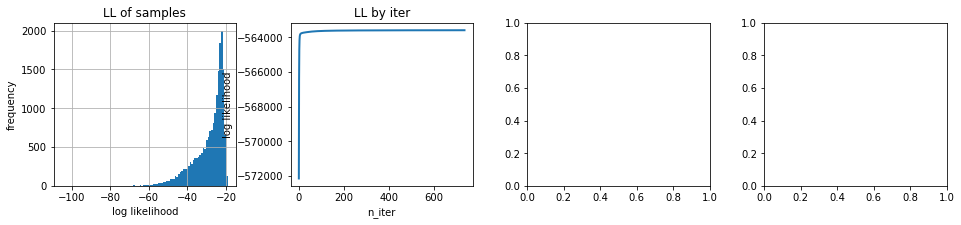

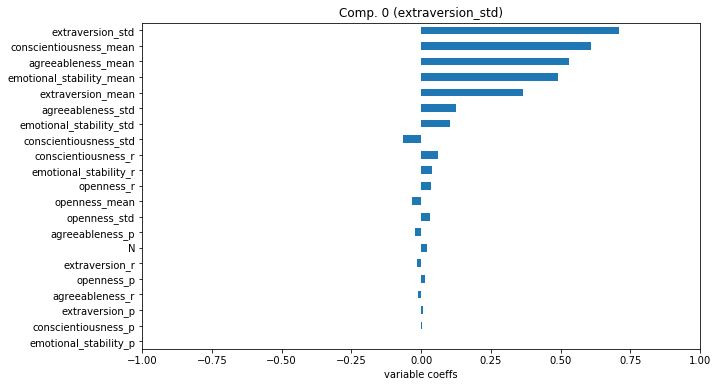

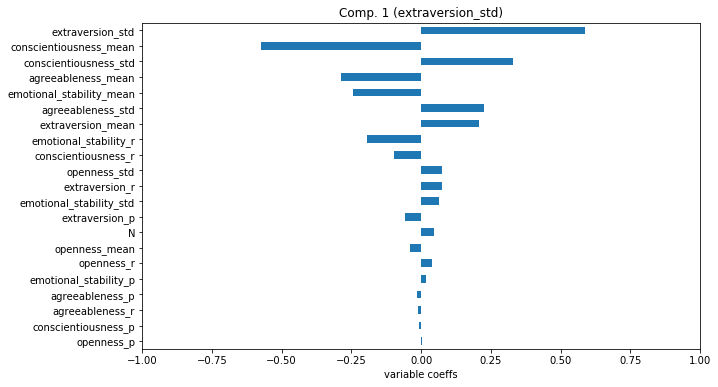

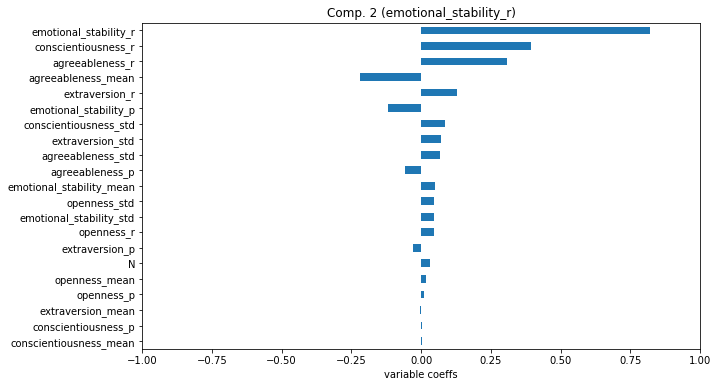

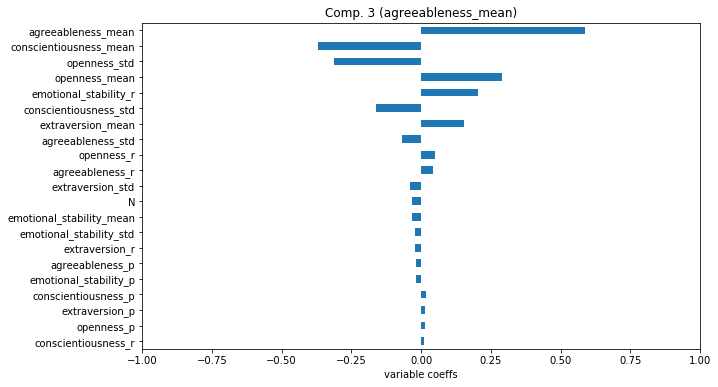

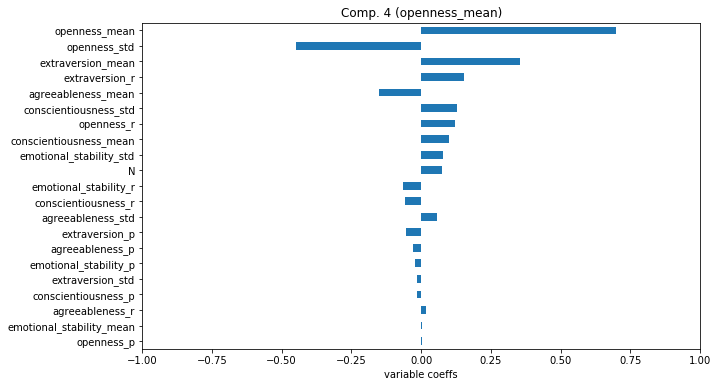

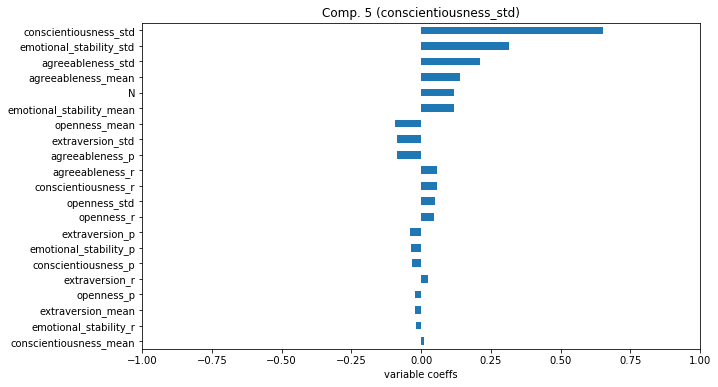

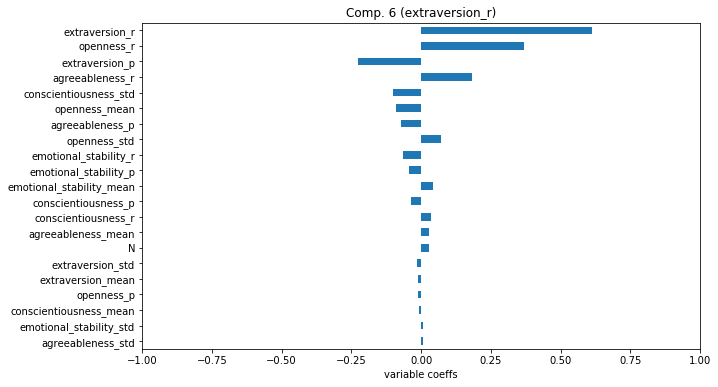

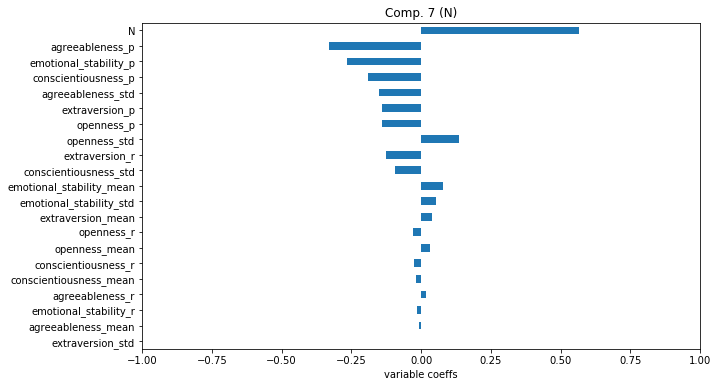

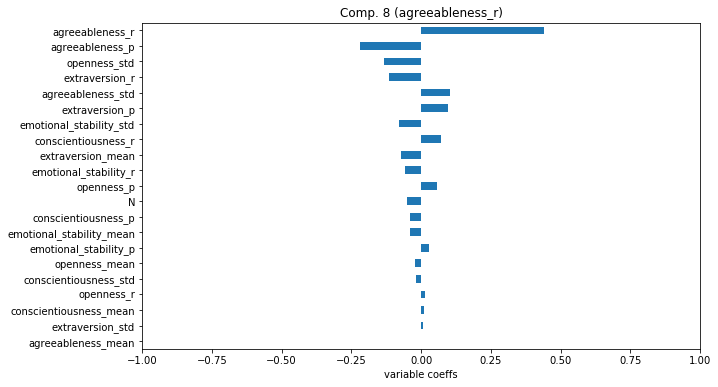

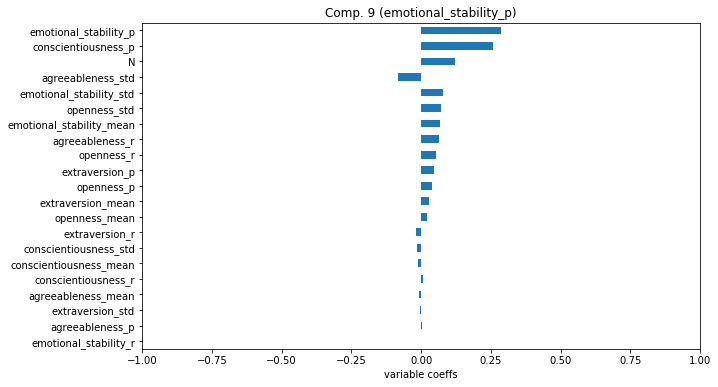

In [96]:
%%time
output_subfolder = ".."+os.sep+"Output"+os.sep+"PERS_big5"
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
n_components = 10

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     BES_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 

display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= n_components, show_histogram = False)

In [94]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
#         NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
#         display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

,noise_variance_
extraversion_std,0.118602
agreeableness_mean,0.291571
extraversion_r,0.331495
openness_mean,0.359885
conscientiousness_std,0.408688
agreeableness_r,0.419748
emotional_stability_r,0.439343
emotional_stability_std,0.471328
conscientiousness_mean,0.511207
emotional_stability_mean,0.530584


In [97]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
#         NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
#         display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

,noise_variance_
extraversion_std,0.135200
conscientiousness_mean,0.156730
agreeableness_mean,0.199323
emotional_stability_r,0.236435
conscientiousness_std,0.394091
openness_mean,0.407235
extraversion_r,0.546442
N,0.638469
openness_std,0.645468
extraversion_mean,0.666898


In [ ]:
#########################################
# Cast/Crew

In [104]:
TMB_crew[0:1000].groupby("movieId").apply(lambda x: x["job"].value_counts())

movieId                                
1        Animation                         26
         Character Designer                 8
         Visual Effects                     5
         Assistant Editor                   4
         Screenplay                         4
         Original Story                     4
         Assistant Sound Editor             4
         Set Dresser                        3
         Producer                           2
         Orchestrator                       2
         Editor                             2
         Executive Producer                 2
         Sound Re-Recording Mixer           2
         Negative Cutter                    2
         Lighting Supervisor                2
         Animation Director                 2
         CG Painter                         2
         Sculptor                           2
         Layout                             2
         Production Coordinator             2
         Supervising Technical Director 

In [109]:
TMB_crew[ TMB_crew["job"]=="Director" ]

,credit_id,department,id,job,order,max_order,fractional_order,movieId
credit_id,,,,,,,,
52fe4284c3a36847f8024f49,52fe4284c3a36847f8024f49,Directing,7879,Director,0,105,0.000000,1
52fe44bfc3a36847f80a7c7d,52fe44bfc3a36847f80a7c7d,Directing,4945,Director,3,15,0.200000,2
52fe466a9251416c75077a89,52fe466a9251416c75077a89,Directing,26502,Director,0,3,0.000000,3
52fe44779251416c91011acb,52fe44779251416c91011acb,Directing,2178,Director,0,9,0.000000,4
52fe44959251416c75039eef,52fe44959251416c75039eef,Directing,56106,Director,5,6,0.833333,5
52fe4292c3a36847f802916d,52fe4292c3a36847f802916d,Directing,638,Director,0,70,0.000000,6
52fe44959251416c75039da9,52fe44959251416c75039da9,Directing,2226,Director,0,52,0.000000,7
52fe46bdc3a36847f810f76d,52fe46bdc3a36847f810f76d,Directing,18357,Director,2,3,0.666667,8
52fe44dbc3a36847f80ae0f1,52fe44dbc3a36847f80ae0f1,Directing,37710,Director,0,8,0.000000,9


In [116]:
num_directors = TMB_crew[ TMB_crew["job"]=="Director" ].groupby("movieId").count()["job"]#.value_counts()
TMB_crew.shape, num_directors.shape

((463836, 8), (44545,))

In [117]:
TMB_crew[ TMB_crew["job"]=="Producer" ].groupby("movieId").count()["job"].value_counts()

1     10648
2      5917
3      2891
4      1365
5       621
6       298
7       131
8        54
9        28
10       14
12        7
11        4
13        2
15        1
17        1
22        1
20        1
14        1
16        1
Name: job, dtype: int64

In [119]:
TMB_crew.groupby("movieId").apply(lambda x: x["job"][0]).value_counts()

Director                            25508
Producer                             2792
Screenplay                           2697
Writer                               2012
Director of Photography              1926
Original Music Composer              1552
Editor                               1407
Casting                              1380
Executive Producer                   1047
Music                                 648
Art Direction                         402
Production Design                     396
Novel                                 346
Cinematography                        298
Costume Design                        297
Story                                 224
Set Decoration                        161
Author                                121
Co-Producer                            86
Makeup Artist                          75
Characters                             69
Associate Producer                     61
Sound Designer                         58
Theatre Play                      

In [100]:
TMB_crew["job"].value_counts()

Director                          48999
Producer                          43507
Writer                            30398
Screenplay                        25143
Editor                            23770
Director of Photography           20640
Executive Producer                18853
Original Music Composer           15773
Casting                           12620
Art Direction                     11679
Costume Design                    11010
Production Design                 10524
Set Decoration                     7543
Music                              7333
Makeup Artist                      6400
Story                              5809
Novel                              5119
Script Supervisor                  4321
Cinematography                     4206
Camera Operator                    4123
Animation                          3828
Sound Re-Recording Mixer           3677
Associate Producer                 3592
Hairstylist                        3537
Co-Producer                        3182


In [ ]:
#####################

In [310]:
# https://github.com/seanabu/movie_data_scraper/blob/master/the_numbers_scrape.ipynb
import requests
from bs4 import BeautifulSoup
import string
# import urlparse 
from urllib.parse import urlparse
from urllib.request import urlopen
import re
import locale
import pickle
from dateutil import parser


from urllib.request import urlopen
from bs4 import BeautifulSoup
import re 
from collections import defaultdict 
from pandas import Series, DataFrame 
import numpy as np 
from bs4 import BeautifulSoup
import re 
import sys
sys.setrecursionlimit(20000)
import unidecode
import unicodedata

import urllib

In [286]:
# https://www.the-numbers.com/movie/budgets/all/101


In [322]:
# def make_polite_request(url):

#     req = urllib.request.Request(
#         url, 
#         data=None, 
#         headers={
#             'User-Agent': 'Respectful Scraper Bot'
#         }
#     )
#     return req
# # url = 'http://www.the-numbers.com/movie/budgets/all'


In [323]:
url_list = ['https://www.the-numbers.com/movie/budgets/all/1']+['https://www.the-numbers.com/movie/budgets/all/%d' % (x) for x in range(101, 5800,100)]

scrape_count = 1
df = pd.DataFrame(columns = ["date","title","link","page_no","production_budget","domestic_gross","worldwide_gross","scrape_count"])

for url in url_list:
    response = requests.get(url)
#     response = urllib.request.urlopen(make_polite_request(url))
    page = response.text
    soup = BeautifulSoup(page)
    rows = soup.find('table').find_all('tr')[1:101]

    for row in rows:

        date = row.a.text
        title = row.b.a.text
        link = row.b.a.get('href')
        page_no = row.find_all("td")[0].text
        production_budget = row.find_all("td")[3].text
        domestic_gross = row.find_all("td")[4].text
        worldwide_gross = row.find_all("td")[5].text    

        df = df.append({'date': date, 'title': title, 'link':link, 'page_no':page_no,
                   'production_budget': production_budget, 'domestic_gross': domestic_gross,
                   'worldwide_gross': worldwide_gross,'scrape_count':scrape_count}, ignore_index=True)

        scrape_count = scrape_count+1



In [318]:
url = 'https://www.the-numbers.com/movie/budgets/all/1'
response = requests.get(url)
# response = urllib.request.urlopen(make_polite_request(url))

In [320]:
page = response.text
soup = BeautifulSoup(page)
rows = soup.find('table').find_all('tr')[1:101]
rows

[<tr><td class="data">1</td>
 <td><a href="/box-office-chart/daily/2009/12/18">Dec 18, 2009</a></td>
 <td><b><a href="/movie/Avatar#tab=summary">Avatar</a></b></td>
 <td class="data">$425,000,000</td>
 <td class="data">$760,507,625</td>
 <td class="data">$2,776,345,279</td>
 </tr>, <tr><td class="data">2</td>
 <td><a href="/box-office-chart/daily/2011/05/20">May 20, 2011</a></td>
 <td><b><a href="/movie/Pirates-of-the-Caribbean-On-Stranger-Tides#tab=summary">Pirates of the Caribbean: On Stranger Tides</a></b></td>
 <td class="data">$410,600,000</td>
 <td class="data">$241,063,875</td>
 <td class="data">$1,045,663,875</td>
 </tr>, <tr><td class="data">3</td>
 <td><a href="/box-office-chart/daily/2015/05/01">May 1, 2015</a></td>
 <td><b><a href="/movie/Avengers-Age-of-Ultron#tab=summary">Avengers: Age of Ultron</a></b></td>
 <td class="data">$330,600,000</td>
 <td class="data">$459,005,868</td>
 <td class="data">$1,403,013,963</td>
 </tr>, <tr><td class="data">4</td>
 <td><a href="/box-o

In [296]:
soup = BeautifulSoup(page)


In [267]:
date = rows[1].a.text
title = rows[1].b.a.text
link = rows[1].b.a.get('href')
page_no = rows[1].find_all("td")[0].text
production_budget = rows[1].find_all("td")[3].text
domestic_gross = rows[1].find_all("td")[4].text
worldwide_gross = rows[1].find_all("td")[5].text

In [272]:
df.append({'date': date, 'title': title, 'link':link, 'page_no':page_no,
               'production_budget': production_budget, 'domestic_gross': domestic_gross,
               'worldwide_gross': worldwide_gross}, ignore_index=True)

,date,title,link,page_no,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,/movie/Avatar#tab=summary,1,"$425,000,000","$760,507,625","$2,776,345,279"


In [271]:
{'date': date, 'title': title, 'link':link, 'page_no':page_no,
               'production_budget': production_budget, 'domestic_gross': domestic_gross,
               'worldwide_gross': worldwide_gross}

{'date': 'Dec 18, 2009',
 'title': 'Avatar',
 'link': '/movie/Avatar#tab=summary',
 'page_no': '1',
 'production_budget': '$425,000,000',
 'domestic_gross': '$760,507,625',
 'worldwide_gross': '$2,776,345,279'}

In [324]:
df

,date,title,link,page_no,production_budget,domestic_gross,worldwide_gross,scrape_count
0,"Dec 18, 2009",Avatar,/movie/Avatar#tab=summary,1,"$425,000,000","$760,507,625","$2,776,345,279",1
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,/movie/Pirates-of-the-Caribbean-On-Stranger-Ti...,2,"$410,600,000","$241,063,875","$1,045,663,875",2
2,"May 1, 2015",Avengers: Age of Ultron,/movie/Avengers-Age-of-Ultron#tab=summary,3,"$330,600,000","$459,005,868","$1,403,013,963",3
3,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,/movie/Star-Wars-Ep-VIII-The-Last-Jedi#tab=sum...,4,"$317,000,000","$620,181,382","$1,316,721,747",4
4,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,/movie/Star-Wars-Ep-VII-The-Force-Awakens#tab=...,5,"$306,000,000","$936,662,225","$2,053,311,220",5
5,"Apr 27, 2018",Avengers: Infinity War,/movie/Avengers-Infinity-War#tab=summary,6,"$300,000,000","$678,815,482","$2,048,134,200",6
6,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,/movie/Pirates-of-the-Caribbean-At-Worlds-End#...,7,"$300,000,000","$309,420,425","$963,420,425",7
7,"Nov 17, 2017",Justice League,/movie/Justice-League-(2017)#tab=summary,8,"$300,000,000","$229,024,295","$655,945,209",8
8,"Nov 6, 2015",Spectre,/movie/Spectre#tab=summary,9,"$300,000,000","$200,074,175","$879,620,923",9
9,"Jul 20, 2012",The Dark Knight Rises,/movie/Dark-Knight-Rises-The#tab=summary,10,"$275,000,000","$448,139,099","$1,084,439,099",10


In [351]:
df.dtypes

date                 object
title                object
link                 object
page_no               int32
production_budget     int64
domestic_gross        int64
worldwide_gross       int64
scrape_count          int32
dtype: object

In [356]:

# pd.to_datetime(SER_movies["releaseDate"]).apply(lambda x: x.date())

In [345]:
df_safe = df.copy()

In [346]:
df["production_budget"] = df["production_budget"].apply(lambda x: int( "".join( x.split("$")[1].split(",") ) ) )
df["domestic_gross"]    = df["domestic_gross"   ].apply(lambda x: int( "".join( x.split("$")[1].split(",") ) ) )
df["worldwide_gross"]   = df["worldwide_gross"  ].apply(lambda x: int( "".join( x.split("$")[1].split(",") ) ) )
df["scrape_count"] = df["scrape_count"].astype('int')
df["page_no"]      = df["page_no"].astype('int')

df["date"] = pd.to_datetime(df["date"]).apply(lambda x: x.date())
df["release_year"]  = df["date"].apply(lambda x: x.year)
df["release_month"] = df["date"].apply(lambda x: x.month)
df["release_day"]   = df["date"].apply(lambda x: x.day)

In [361]:
NUM_movies=df.copy()
NUM_movies.to_csv(Dataset_directory+"Processed"+os.sep+"NUM_movies"+".csv")